# 评分卡建模 v2.2
#### 应用场景 (目标): 提供信用住产品给部分高分的用户 --- 即抓好用户

- Good: 无Noshow, 并且较活跃:
  + 789月订单 >= 3 并且 789月noshow订单 = 0
- Bad:  Noshow 率较高的用户: 
  + (789月订单 <= 5 且 789月noshow订单 > 0) 或者 (789月订单 > 5 且 noshow% >= 0.2)

#### 建模方法:
- 选出正负样本数据, 其中, 注册时长 >= 0
- Bad: 596052   Good: 1234434
- 计算所有变量的 Information Value
- 剔除 IV 过低的变量, 剩余的变量做 WOE 切割
- 通过 Penalized Logistic 方法进行变量, 该方法能够处理共线性问题
- 变量可解释性: 剔除回归参数为负的变量

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from math import floor, ceil, log
% matplotlib inline

In [1]:
# 数据太大了, 分块读
reader = pd.read_csv('E:/work/Credit_ScoreCard/v2_Model/v2.2/ltl_credit_model_df.txt', sep = '\t', dtype = {'uid': str,'gold_user_level':str}, iterator = True)
chunks = []
loop = True
i = 1
while loop:
    try:
        chunk = reader.get_chunk(300000)
        chunks.append(chunk)
        print i
        i += 1
    except StopIteration:
        loop = False
        print 'Iteration is stopped.'
df_model = pd.concat(chunks, ignore_index = True)

In [4]:
df_model.shape

(1830486, 78)

In [5]:
df_model.head()

,uid,y_flag,gold_user_level,vip_grade,registerduration,customer_value,bound_valid_email,member_level,real_name_certify,htl_consuming_capacity,...,last_year_complains,last_6m_complains,credit_card_succ_num,credit_card_fail_num,credit_card_succ_rate,htl_advanced_date,recent5_noshow_rate,recent10_noshow_rate,recent15_noshow_rate,recent20_noshow_rate
0,00000327,1,G,30,5518,71.46,1,30,0,39,...,0,0,35,3,0.921053,0.058824,0,0,0,0.055556
1,00000888,1,G,20,5518,76.43,1,20,1,53,...,38,38,38,0,1.000000,4.388889,0,0,0,0.050000
2,00000891,1,G,0,5518,-1.00,0,-1,0,71,...,0,0,0,0,-1.000000,3.400000,0,0,0,0.000000
3,00001197,0,G,10,5511,75.38,0,10,0,43,...,0,0,0,0,-1.000000,7.090909,0,0,0,0.000000
4,00001449,1,G,30,5518,87.66,1,30,1,80,...,0,0,25,0,1.000000,0.456522,0,0,0,0.050000


In [6]:
# 找出存在缺失值的变量
df_model.isnull().any()[df_model.isnull().any() == True]

Series([], dtype: bool)

In [7]:
# 导出相关性矩阵
df_model.corr(method='pearson', min_periods=1).to_csv('E:/work/Credit_ScoreCard/v2_Model/v2.2/corr_py.csv', sep=',')

## 分20组, 计算所有变量的 Information Value

# 计算总的坏用户和好用户

In [8]:
count_1 = float(df_model.y_flag.sum())
count_0 = df_model.y_flag.count() - float(df_model.y_flag.sum())
print 'Good:',count_1, '\n', 'Bad:', count_0
# ------------------------------------------------------------------------------------------------------------------------------------------
# 函数 rude_group_rate : 分组,输出 flag_rate, group_count, information_value, groups, var_woe
def rude_group_rate(data, var, rank_group = 'null', set = 20):
    if rank_group is 'null':
        if len(data[var].unique()) > 6:
            group_count = ceil(data[var].rank().max() / set)
            rank_group = pd.Series([floor(i) for i in data[var].rank() / group_count])
        else:
            rank_group = data[var]
    rank_group = rank_group.replace(np.nan, -1)
    group_count = data.y_flag.groupby([rank_group]).count()
    flag_rate = data.y_flag.groupby([rank_group]).sum() / data.y_flag.groupby([rank_group]).count()
    percent_1 = data.y_flag.groupby([rank_group]).sum() / count_1
    percent_0 = (data.y_flag.groupby([rank_group]).count() - data.y_flag.groupby([rank_group]).sum()) / count_0
    information_value = sum([a*b for a,b in zip(list(percent_1 - percent_0), [log(i) for i in (percent_1 / percent_0)])])
# ---------------------------------------------------------------------------------------------------------------
    unique_rank = rank_group.unique()
    group_woe = [log(percent_1[i] / percent_0[i]) for i in unique_rank]
    var_woe = rank_group
    for i,rank in enumerate(unique_rank):
        var_woe = var_woe.replace(rank, group_woe[i])
    woe = [round(k,2) for k in var_woe.groupby(var_woe).max()]
    if len(data[var].unique()) < 10:
        group = data[var].groupby(var_woe).unique()
        groups = zip(group, woe)
    else:
        group_min = data[var].groupby(var_woe).min()
        group_max = data[var].groupby(var_woe).max()
        groups = zip(group_min, group_max, woe)
    return flag_rate, group_count, rank_group, information_value, groups, var_woe

Good: 1234434.0 
Bad: 596052.0


In [9]:
colnames = df_model.columns[~df_model.columns.isin(['uid', 'deal_orders_789m', 'noshow_orders_789m', 'y_flag',])]
colnames = colnames[~colnames.isin(['gold_user_level'])]

In [17]:
IV = {}
for colname in colnames:
    information_value = rude_group_rate(data=df_model, var=colname)[3]
    IV[colname] = information_value

In [20]:
IV['gold_user_level'] = 0.164618009459

In [21]:
IV_sort = sorted(IV.iteritems(), key = lambda d: d[1], reverse = True)
for i, j in IV_sort:
    print i,j

profile_advanced_date 1.07999820612
ctrip_cash_amount 0.861795330258
htl_consuming_capacity 0.712960156507
avg_htl_star 0.680349479632
htl_star_prefer 0.643619034316
generous_stingy_tag 0.554954816095
last_year_deal_amount 0.473575104422
customer_value 0.43462950216
last_6m_deal_amount 0.403178755565
max_deal_price 0.39670770612
recent20_noshow_rate 0.388134084453
recent15_noshow_rate 0.374938193752
last_year_deal_orders 0.374640161807
age 0.357588956273
recent10_noshow_rate 0.352243263074
credit_card_succ_num 0.341008645887
city_num 0.338948172533
avg_deal_price 0.330575097131
vip_grade 0.329835863785
guarantee_last_year_deal_orders 0.328434130097
provice_num 0.317207768492
last_6m_deal_orders 0.312144059909
fguarantee_last_year_deal_orders 0.311811119147
recent5_noshow_rate 0.310625210049
credit_card_succ_rate 0.301235569505
htl_advanced_date 0.263931176055
fguarantee_last_6m_deal_orders 0.256736535536
guarantee_last_6m_deal_orders 0.233347775826
real_name_certify 0.231051811529
coun

## 人工初选, 并将重要的变量转为 WOE

##### 'gold_user_level' 是字符串, 转化为 woe
- G：普通会员,T：信用会员,N：新会员,F：NoShow会员

In [8]:
df_model['gold_user_level'].groupby(df_model['gold_user_level']).count()

gold_user_level
       89511
@       6779
F         84
G    1105982
N     628130
Name: gold_user_level, dtype: int64

In [9]:
# 细分: ['N'], ['G'], ['F','@', ' ']
group = df_model['gold_user_level'].replace(['F','@', ' '], 0).replace('G', 1).replace('N', 2)
flag_rate, group_count, rank_group, information_value, groups, df_model['gold_user_level_woe'] = rude_group_rate(df_model, 'gold_user_level', rank_group=group)
print pd.DataFrame({'flag_rate':flag_rate, 'group_count': group_count}), '\n'
print groups, '\n'
print 'IV:', information_value

                 flag_rate  group_count
gold_user_level                        
0                 0.545718        96374
1                 0.746771      1105982
2                 0.566644       628130 

[(array([' ', '@', 'F'], dtype=object), -0.54), (array(['N'], dtype=object), -0.46), (array(['G'], dtype=object), 0.35)] 

IV: 0.164618009459


##------------------------------------------------------------------------------------------------------------------------------------

#### 'credit_card_fail_num' 
- [0, 非0]
- 刷卡失败次数多的用户反而好, 不符合实际, 删除该变量, 检查数据源头

   flag_rate  group_count
4   0.658486      1596709
9   0.800519       224944 



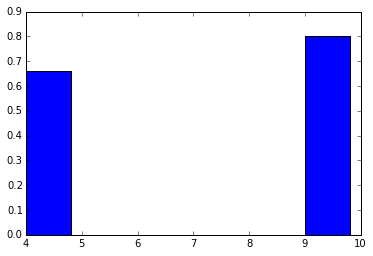

[(0, 0, -0.08), (1, 6222, 0.65)] 

IV: 0.0514493518595


In [26]:
flag_rate, group_count, rank_group, information_value, groups, df_model['credit_card_fail_num_woe'] = rude_group_rate(df_model, 'credit_card_fail_num',set = 10)
print pd.DataFrame({'flag_rate':flag_rate, 'group_count': group_count}), '\n'
plt.figure()
plt.bar(flag_rate.index, flag_rate.values)
plt.show()
print groups, '\n'
print 'IV:', information_value

#####  last_year_cancel_orders
- 不符合实际, 取消越多用户越好

   flag_rate  group_count
3   0.651355      1351489
8   0.743853       242095
9   0.750216       228069 



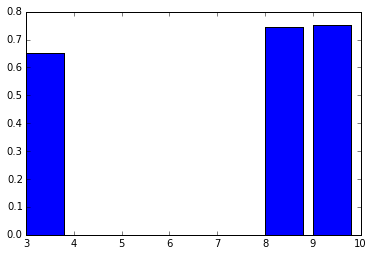

[(0, 0, -0.11), (1, 1, 0.33), (2, 53863, 0.36)] 

IV: 0.0382894504728


In [27]:
flag_rate, group_count, rank_group, information_value, groups, df_model['last_year_cancel_orders_woe'] = rude_group_rate(df_model, 'last_year_cancel_orders',set=10)
print pd.DataFrame({'flag_rate':flag_rate, 'group_count': group_count}), '\n'
plt.figure()
plt.bar(flag_rate.index, flag_rate.values)
plt.show()
print groups, '\n'
print 'IV:', information_value

##### last_year_complains 
- 不合实际, 投诉越多越好

   flag_rate  group_count
2   0.665920      1693029
4   0.809033       128624 



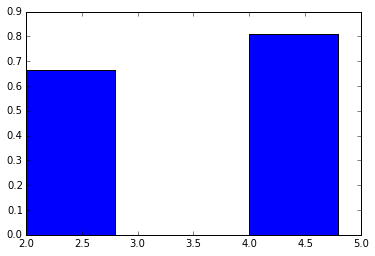

[(0, 0, -0.05), (1, 53448, 0.71)] 

IV: 0.03232949224


In [28]:
flag_rate, group_count, rank_group, information_value, groups, df_model['last_year_complains_woe'] = rude_group_rate(df_model, 'last_year_complains',set=5)
print pd.DataFrame({'flag_rate':flag_rate, 'group_count': group_count}), '\n'
plt.figure()
plt.bar(flag_rate.index, flag_rate.values)
plt.show()
print groups, '\n'
print 'IV:', information_value

##### guarantee_last_year_cancel_orders
- 不合实际

   flag_rate  group_count
2   0.666600      1711021
4   0.821797       110632 



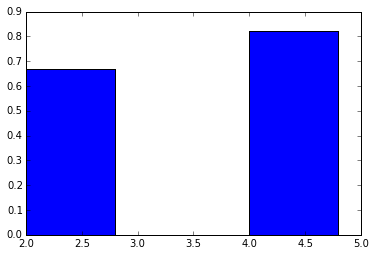

[(0, 0, -0.04), (1, 1002, 0.79)] 

IV: 0.0337812201769


In [29]:
flag_rate, group_count, rank_group, information_value, groups, df_model['guarantee_last_year_cancel_orders_woe'] = rude_group_rate(df_model, 'guarantee_last_year_cancel_orders',set=5)
print pd.DataFrame({'flag_rate':flag_rate, 'group_count': group_count}), '\n'
plt.figure()
plt.bar(flag_rate.index, flag_rate.values)
plt.show()
print groups, '\n'
print 'IV:', information_value

##### online_last_year_cancel_orders
- 不合实际

   flag_rate  group_count
2   0.667578      1714469
4   0.811138       107184 



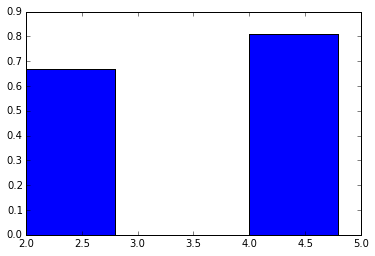

[(0, 0, -0.04), (1, 36726, 0.72)] 

IV: 0.0275928721015


In [31]:
flag_rate, group_count, rank_group, information_value, groups, df_model['online_last_year_cancel_orders_woe'] = rude_group_rate(df_model, 'online_last_year_cancel_orders',set=5)
print pd.DataFrame({'flag_rate':flag_rate, 'group_count': group_count}), '\n'
plt.figure()
plt.bar(flag_rate.index, flag_rate.values)
plt.show()
print groups, '\n'
print 'IV:', information_value

##### fguarantee_last_year_cancel_orders
- 不合实际

   flag_rate  group_count
2   0.657393      1402021
4   0.740396       224631
5   0.735832       195001 



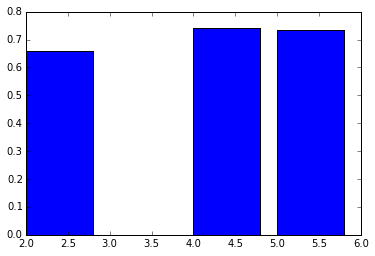

[(0, 0, -0.08), (2, 53861, 0.29), (1, 1, 0.31)] 

IV: 0.0252593001201


In [32]:
flag_rate, group_count, rank_group, information_value, groups, df_model['fguarantee_last_year_cancel_orders_woe']  = rude_group_rate(df_model, 'fguarantee_last_year_cancel_orders',set=6)
print pd.DataFrame({'flag_rate':flag_rate, 'group_count': group_count}), '\n'
plt.figure()
plt.bar(flag_rate.index, flag_rate.values)
plt.show()
print groups, '\n'
print 'IV:', information_value

##### customer_eval
- 携程用户给酒店做的评级, 删除该变量

##------------------------------------------------------------------------------------------------------------------------------------

#### 'gender'

        flag_rate  group_count
gender                        
-1       0.448775       119347
 0       0.722265       558598
 1       0.674525      1152541 



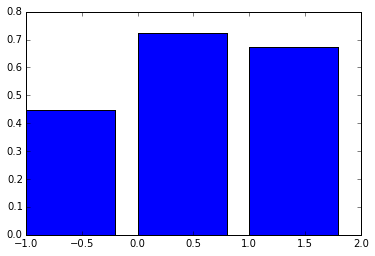

[(array([-1], dtype=int64), -0.93), (array([1], dtype=int64), 0.0), (array([0], dtype=int64), 0.23)] 

IV: 0.0776925985425


In [10]:
flag_rate, group_count, rank_group, information_value, groups, df_model['gender_woe'] = rude_group_rate(df_model, 'gender')
print pd.DataFrame({'flag_rate':flag_rate, 'group_count': group_count}), '\n'
plt.figure()
plt.bar(flag_rate.index, flag_rate.values)
plt.show()
print groups, '\n'
print 'IV:', information_value

##### 'credit_card_succ_num'

   flag_rate  group_count
1   0.559833       907864
3   0.702162       142571
4   0.752654       232140
5   0.808974       270722
6   0.854816       268356 



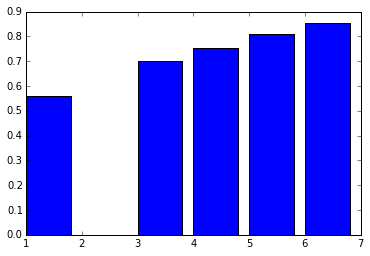

[(0, 0, -0.5), (1, 1, 0.12), (2, 4, 0.38), (5, 13, 0.71), (14, 47226, 1.04)] 

IV: 0.337457305933


In [33]:
flag_rate, group_count, rank_group, information_value, groups, df_model['credit_card_succ_num_woe'] = rude_group_rate(df_model, 'credit_card_succ_num', set = 7)
print pd.DataFrame({'flag_rate':flag_rate, 'group_count': group_count}), '\n'
plt.figure()
plt.bar(flag_rate.index, flag_rate.values)
plt.show()
print groups, '\n'
print 'IV:', information_value

##### credit_card_succ_rate

     flag_rate  group_count
-10   0.558798       898331
 0    0.656760         9556
 1    0.608247           97
 2    0.620635          630
 3    0.672860         1776
 4    0.666286          875
 5    0.702453        11168
 6    0.734106        13370
 7    0.751553        17545
 8    0.787318        53761
 9    0.847021       116166
 10   0.786716       698378 



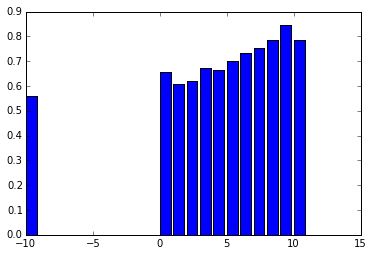

[(-1.0, -1.0, -0.5), (0.10000000000000001, 0.19047619047619047, -0.3), (0.20000000000000001, 0.29545454545454553, -0.24), (0.0, 0.090909090909090925, -0.09), (0.40000000000000002, 0.49038461538461542, -0.04), (0.29999999999999999, 0.39534883720930231, -0.01), (0.5, 0.59615384615384615, 0.12), (0.59999999999999998, 0.69811320754716977, 0.28), (0.69999999999999996, 0.79807692307692313, 0.37), (1.0, 1.0, 0.57), (0.80000000000000004, 0.89932885906040272, 0.57), (0.90000000000000002, 0.99861111111111123, 0.98)] 

IV: 0.301284615431


In [34]:
group = pd.Series([floor(i*10) for i in df_model.credit_card_succ_rate])
flag_rate, group_count, rank_group, information_value, groups, df_model['credit_card_succ_rate_woe'] = rude_group_rate(df_model, 'credit_card_succ_rate', rank_group=group)
print pd.DataFrame({'flag_rate':flag_rate, 'group_count': group_count}), '\n'
plt.figure()
plt.bar(flag_rate.index, flag_rate.values)
plt.show()
print groups, '\n'
print 'IV:', information_value

    flag_rate  group_count
-1   0.558798       898331
 0   0.750860       108778
 1   0.795316       814544 



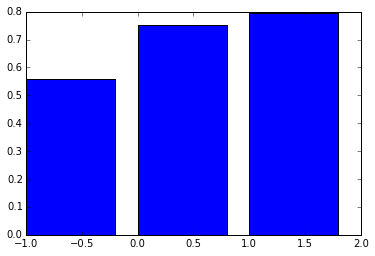

[(-1.0, -1.0, -0.5), (0.0, 0.89932885906040272, 0.37), (0.90000000000000002, 1.0, 0.62)] 

IV: 0.290700822162


In [35]:
# 细分
group = rank_group.replace(-10,-1).replace(range(9),0).replace([9,10],1)
flag_rate, group_count, rank_group, information_value, groups, df_model['credit_card_succ_rate_woe']= rude_group_rate(df_model, 'credit_card_succ_rate', rank_group=group)
print pd.DataFrame({'flag_rate':flag_rate, 'group_count': group_count}), '\n'
plt.figure()
plt.bar(flag_rate.index, flag_rate.values)
plt.show()
print groups, '\n'
print 'IV:', information_value

##### registerduration: 注册时长
- 注册时常按照自然年分区

    flag_rate  group_count
0    0.571992       474370
1    0.653357       282625
2    0.681308       210843
3    0.687099       183617
4    0.712502       141382
5    0.724133       123777
6    0.739973       118076
7    0.766783       100443
8    0.787143        57292
9    0.803507        42027
10   0.814837        31799
11   0.819150        22068
12   0.827249        12764
13   0.836959        11445
14   0.863038         7754
15   0.903720         1371 



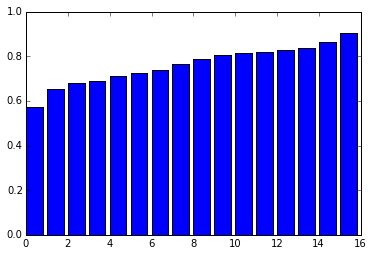

[(0, 365, -0.45), (366, 730, -0.1), (731, 1095, 0.02), (1096, 1460, 0.05), (1461, 1825, 0.17), (1826, 2190, 0.23), (2191, 2555, 0.31), (2556, 2920, 0.45), (2921, 3285, 0.57), (3286, 3650, 0.67), (3651, 4015, 0.75), (4016, 4380, 0.78), (4381, 4745, 0.83), (4746, 5110, 0.9), (5111, 5475, 1.11), (5476, 5762, 1.5)] 

IV: 0.124910975902


In [36]:
group = pd.Series([floor(i/365.01) for i in df_model.registerduration])
flag_rate, group_count, rank_group, information_value, groups, df_model['registerduration_woe'] = rude_group_rate(df_model, 'registerduration', rank_group = group)
print pd.DataFrame({'flag_rate':flag_rate, 'group_count': group_count}), '\n'
plt.figure()
plt.bar(flag_rate.index, flag_rate.values)
plt.show()
print groups, '\n'
print 'IV:', information_value

   flag_rate  group_count
0   0.571992       474370
1   0.653357       282625
2   0.684003       394460
3   0.724722       383235
4   0.794322       286963 



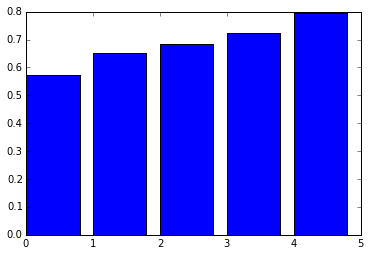

[(0, 365, -0.45), (366, 730, -0.1), (731, 1460, 0.04), (1461, 2555, 0.23), (2556, 5762, 0.62)] 

IV: 0.120291430327


In [37]:
#细分 : [-1,0] [1] [2,3] [4,5,6] [7,8,9,10,11,12,13]
group = rank_group.replace([-1,0],0).replace([2,3],2).replace([4,5,6],3).replace([7,8,9,10,11,12,13,14,15,16,17,18,19,20],4)
flag_rate, group_count, rank_group, information_value, groups, df_model['registerduration_woe'] = rude_group_rate(df_model, 'registerduration', rank_group = group)
print pd.DataFrame({'flag_rate':flag_rate, 'group_count': group_count}), '\n'
plt.figure()
plt.bar(flag_rate.index, flag_rate.values)
plt.show()
print groups, '\n'
print 'IV:', information_value

##### htl_advanced_date --提前预订天数

   flag_rate  group_count
0   0.498378       392152
1   0.627119       333999
2   0.719418       365262
3   0.761577       359479
4   0.782280       370761 



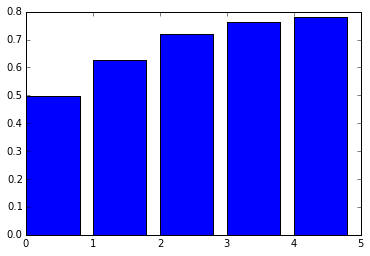

[(-1.0, -1.0, -0.74), (0.0, 0.24882629107981225, -0.22), (0.25, 1.1984126984126984, 0.21), (1.2, 3.993269230769231, 0.43), (4.0, 296.5294117647058, 0.54)] 

IV: 0.233067039724


In [56]:
flag_rate, group_count, rank_group, information_value, groups, df_model['htl_advanced_date_woe'] = rude_group_rate(df_model, 'htl_advanced_date', set = 5)
print pd.DataFrame({'flag_rate':flag_rate, 'group_count': group_count}), '\n'
plt.figure()
plt.bar(flag_rate.index, flag_rate.values)
plt.show()
print groups, '\n'
print 'IV:', information_value

##### profile_advanced_date  -- 小于 0 的用户占比比较多

In [39]:
sum(df_model.profile_advanced_date < 0 )

156625

In [59]:
aa = pd.Series(df_model.profile_advanced_date.unique())
aa = list(aa[aa<0])
profile_advanced_date = df_model['profile_advanced_date'].replace(aa, np.nan)
group_count = ceil(profile_advanced_date.rank().max() / 10)
group = pd.Series([floor(i) for i in profile_advanced_date.rank() / group_count])
del profile_advanced_date
del group_count
del aa

    flag_rate  group_count
-1   0.191017       156625
 0   0.433152       170910
 1   0.750667       162241
 2   0.706449       164234
 3   0.768468       154700
 4   0.682804       174589
 5   0.732683       172451
 6   0.760358       166348
 7   0.779652       167263
 8   0.797046       165796
 9   0.818284       166496 



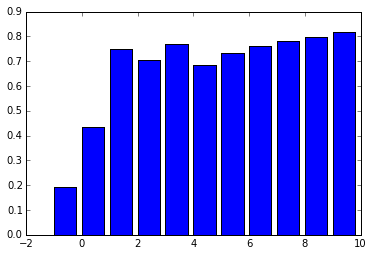

[(-77.0, -0.0018018018018018016, -2.18), (0.0, 0.0, -1.0), (1.0, 1.4970414201183433, 0.03), (0.28019323671497592, 0.57077625570776258, 0.14), (1.5, 2.2857142857142856, 0.27), (0.0026809651474530827, 0.28000000000000003, 0.37), (2.2868217054263567, 3.5446428571428568, 0.42), (0.5714285714285714, 0.99630996309963094, 0.46), (3.5454545454545454, 5.6666666666666679, 0.53), (5.668292682926829, 10.210526315789474, 0.63), (10.211267605633802, 199.0, 0.77)] 

IV: 0.670864681914


In [60]:
flag_rate, group_count, rank_group, information_value, groups, df_model['profile_advanced_date_woe'] = rude_group_rate(df_model, 'profile_advanced_date',rank_group=group)
print pd.DataFrame({'flag_rate':flag_rate, 'group_count': group_count}), '\n'
plt.figure()
plt.bar(flag_rate.index, flag_rate.values)
plt.show()
print groups, '\n'
print 'IV:', information_value

    flag_rate  group_count
-1   0.191017       156625
 0   0.587779       333151
 1   0.717525       493523
 2   0.757304       506062
 3   0.807687       332292 



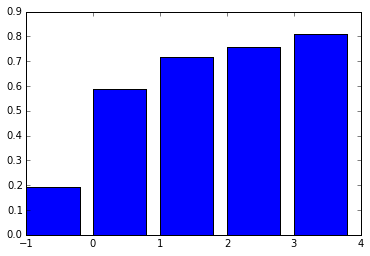

[(-77.0, -0.0018018018018018016, -2.18), (0.0, 0.28000000000000003, -0.38), (0.28019323671497592, 1.4970414201183433, 0.2), (1.5, 5.6666666666666679, 0.4), (5.668292682926829, 199.0, 0.7)] 

IV: 0.571225004696


In [61]:
group = rank_group.replace([0,1],0).replace([2,3,4],1).replace([5,6,7],2).replace([8,9],3)
flag_rate, group_count, rank_group, information_value, groups, df_model['profile_advanced_date_woe'] = rude_group_rate(df_model, 'profile_advanced_date',rank_group=group)
print pd.DataFrame({'flag_rate':flag_rate, 'group_count': group_count}), '\n'
plt.figure()
plt.bar(flag_rate.index, flag_rate.values)
plt.show()
print groups, '\n'
print 'IV:', information_value

##### avg_htl_star

    flag_rate  group_count
-1   0.009662        24425
 0   0.256494        15322
 1   0.680140        45373
 2   0.561682       535643
 3   0.730238       624269
 4   0.779406       531683
 5   0.563755        44938 



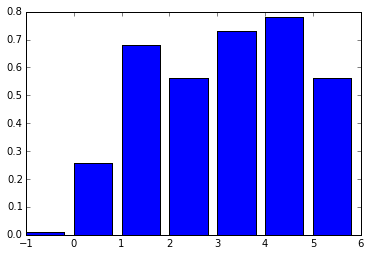

[(-1.0, -1.0, -5.37), (0.0, 0.97297297297297303, -1.8), (2.0, 2.9960000000000004, -0.49), (5.0, 5.0, -0.48), (1.0, 1.9960474308300395, 0.02), (3.0, 3.9978880675818376, 0.26), (4.0, 4.9948320413436695, 0.53)] 

IV: 0.423428801703


In [62]:
# 粗分: [nan] 0 1 2 3 4 5
group = pd.Series([floor(i) for i in df_model['avg_htl_star']])
flag_rate, group_count, rank_group, information_value, groups, df_model['avg_htl_star_woe'] = rude_group_rate(df_model, 'avg_htl_star', rank_group = group)
print pd.DataFrame({'flag_rate':flag_rate, 'group_count': group_count}), '\n'
plt.figure()
plt.bar(flag_rate.index, flag_rate.values)
plt.show()
print groups, '\n'
print 'IV:', information_value

   flag_rate  group_count
0   0.411490        85120
1   0.561682       535643
2   0.730238       624269
3   0.762600       576621 



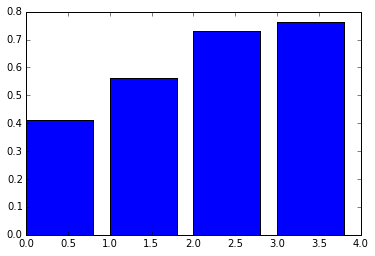

[(-1.0, 1.9960474308300395, -1.09), (2.0, 2.9960000000000004, -0.49), (3.0, 3.9978880675818376, 0.26), (4.0, 5.0, 0.43)] 

IV: 0.212616298212


In [63]:
# 细分: [-1,0,1] [2] [3] [4,5]
group = rank_group.replace([-1,0,1],0).replace(2,1).replace(3,2).replace([4,5],3)
flag_rate, group_count, rank_group, information_value, groups, df_model['avg_htl_star_woe'] = rude_group_rate(df_model, 'avg_htl_star', rank_group = group)
print pd.DataFrame({'flag_rate':flag_rate, 'group_count': group_count}), '\n'
plt.figure()
plt.bar(flag_rate.index, flag_rate.values)
plt.show()
print groups, '\n'
print 'IV:', information_value

##### Htl_Star_Prefer

   flag_rate  group_count
0   0.536805        83861
1   0.400890       275160
2   0.684892       180354
3   0.591351       193873
4   0.770506       165255
5   0.757539       179769
6   0.817051       165106
7   0.664516       194215
8   0.817490       183163
9   0.800321       200897 



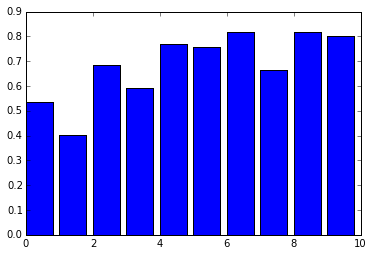

[(40.0, 45.439999999999998, -1.14), (-1.0, 39.920000000000002, -0.59), (54.310000000000002, 60.0, -0.37), (80.0, 83.799999999999997, -0.05), (45.450000000000003, 54.289999999999999, 0.04), (67.780000000000001, 73.739999999999995, 0.4), (60.060000000000002, 67.769999999999996, 0.48), (90.060000000000002, 100.0, 0.65), (73.75, 79.959999999999994, 0.76), (83.810000000000002, 90.0, 0.76)] 

IV: 0.416845712707


In [12]:
flag_rate, group_count, rank_group, information_value, groups, df_model['htl_dtar_prefer_woe'] = rude_group_rate(df_model, 'htl_star_prefer',set=10)
print pd.DataFrame({'flag_rate':flag_rate, 'group_count': group_count}), '\n'
plt.figure()
plt.bar(flag_rate.index, flag_rate.values)
plt.show()
print groups, '\n'
print 'IV:', information_value

   flag_rate  group_count
0   0.432638       359021
1   0.636432       374227
2   0.748882       704345
3   0.808509       384060 



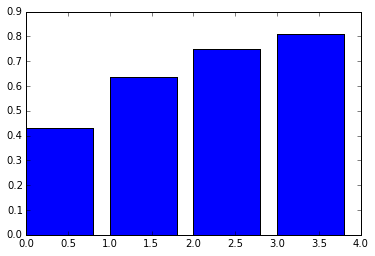

[(-1.0, 45.439999999999998, -1.01), (45.450000000000003, 60.0, -0.18), (60.060000000000002, 83.799999999999997, 0.36), (83.810000000000002, 100.0, 0.7)] 

IV: 0.362812997878


In [10]:
group=rank_group.replace([0,1],0).replace([2,3],1).replace([4,5,6,7],2).replace([8,9],3)
flag_rate, group_count, rank_group, information_value, groups, df_model['htl_star_prefer_woe'] = rude_group_rate(df_model, 'htl_star_prefer',rank_group=group)
print pd.DataFrame({'flag_rate':flag_rate, 'group_count': group_count}), '\n'
plt.figure()
plt.bar(flag_rate.index, flag_rate.values)
plt.show()
print groups, '\n'
print 'IV:', information_value

##### ctrip_cash_amount -- 携程余额

In [64]:
# 细分 [0] (0, 50] (50,200] (200,1000] 1000+
round_cash = pd.Series([ceil(i) for i in df_model.ctrip_cash_amount])
group = round_cash.replace(range(1,51),1).replace(range(51,201),2).replace(range(201,1001),3)
aa = list(set(group) - {0,1,2,3})
group = group.replace(aa, 4)
del aa

   flag_rate  group_count
0   0.245177       101380
1   0.502282       595869
2   0.752125       537655
3   0.849502       432265
4   0.878661       154484 



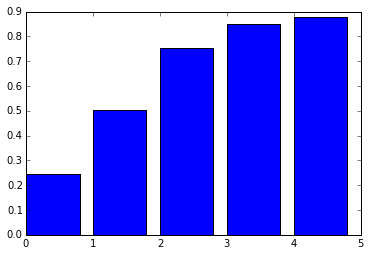

[(0.0, 0.0, -1.86), (0.01, 50.0, -0.73), (50.009999999999998, 200.0, 0.37), (200.00999999999999, 1000.0, 1.0), (1000.02, 1067555.3700000001, 1.24)] 

IV: 0.715207868327


In [65]:
flag_rate, group_count, rank_group, information_value, groups, df_model['ctrip_cash_amount_woe'] = rude_group_rate(df_model, 'ctrip_cash_amount', rank_group = group)
print pd.DataFrame({'flag_rate':flag_rate, 'group_count': group_count}), '\n'
plt.figure()
plt.bar(flag_rate.index, flag_rate.values)
plt.show()
print groups, '\n'
print 'IV:', information_value

##### htl_consuming_capacity

                        flag_rate  group_count
htl_consuming_capacity                        
0                        0.427143       418403
1                        0.684397       666550
2                        0.777992       391468
3                        0.829295       180147
4                        0.863955       165085 



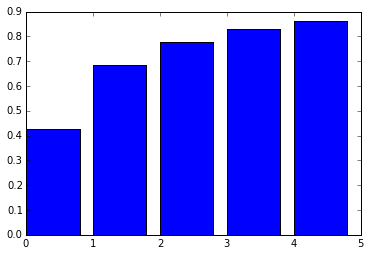

[(-1.0, 20.0, -1.03), (21.0, 40.0, 0.04), (41.0, 60.0, 0.52), (61.0, 80.0, 0.85), (81.0, 100.0, 1.11)] 

IV: 0.466033119573


In [66]:
#细分 [nan,0-20] 21-40 41-60 61-80 81-100
group = df_model['htl_consuming_capacity'].replace(range(-10,21),0).replace(range(21,41),1).replace(range(41,61),2).replace(range(61,81),3).replace(range(81,101),4)
flag_rate, group_count, rank_group, information_value, groups, df_model['htl_consuming_capacity_woe'] = rude_group_rate(df_model, 'htl_consuming_capacity',rank_group=group)
print pd.DataFrame({'flag_rate':flag_rate, 'group_count': group_count}), '\n'
plt.figure()
plt.bar(flag_rate.index, flag_rate.values)
plt.show()
print groups, '\n'
print 'IV:', information_value

##### generous_stingy_tag

                     flag_rate  group_count
generous_stingy_tag                        
0                     0.352623       275223
1                     0.709172       609521
2                     0.749462       936909 



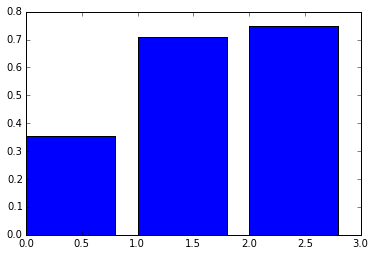

[(array([ 0, -1], dtype=int64), -1.34), (array([1], dtype=int64), 0.16), (array([2, 3], dtype=int64), 0.36)] 

IV: 0.369640270606


In [69]:
# 细分: [-1, 0], [1], [2, 3]
group = rank_group.replace(3,2).replace(-1,0)
flag_rate, group_count, rank_group, information_value, groups, df_model['generous_stingy_tag_woe'] = rude_group_rate(df_model, 'generous_stingy_tag', rank_group=group)
print pd.DataFrame({'flag_rate':flag_rate, 'group_count': group_count}), '\n'
plt.figure()
plt.bar(flag_rate.index, flag_rate.values)
plt.show()
print groups, '\n'
print 'IV:', information_value

##### last_year_deal_amount

   flag_rate  group_count
0   0.515110       489078
1   0.546449       239534
2   0.676115       364367
3   0.778114       364336
4   0.875045       364338 



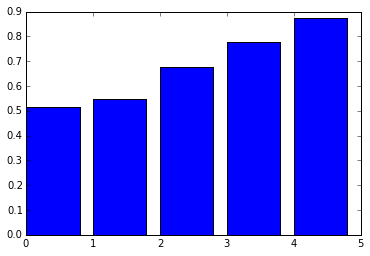

[(0.0, 0.0, -0.68), (1.0, 714.0, -0.55), (715.0, 2680.0, 0.0), (2681.0, 8211.0, 0.52), (8212.0, 669534257.38890028, 1.21)] 

IV: 0.444343576204


In [4]:
flag_rate, group_count, rank_group, information_value, groups, df_model['last_year_deal_amount_woe'] = rude_group_rate(df_model, 'last_year_deal_amount', set=5)
print pd.DataFrame({'flag_rate':flag_rate, 'group_count': group_count}), '\n'
plt.figure()
plt.bar(flag_rate.index, flag_rate.values)
plt.show()
print groups, '\n'
print 'IV:', information_value

##### max_deal_price

   flag_rate  group_count
0   0.515110       489078
1   0.560233       238772
2   0.691356       364980
3   0.776524       364535
4   0.852032       364288 



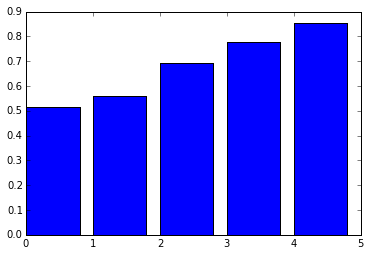

[(0.0, 0.0, -0.68), (1.0, 375.0, -0.49), (376.0, 947.0, 0.07), (948.0, 2185.0, 0.51), (2186.0, 264750.0, 1.02)] 

IV: 0.378314104365


In [11]:
flag_rate, group_count, rank_group, information_value, groups, df_model['max_deal_price_woe'] = rude_group_rate(df_model, 'max_deal_price',set=5)
print pd.DataFrame({'flag_rate':flag_rate, 'group_count': group_count}), '\n'
plt.figure()
plt.bar(flag_rate.index, flag_rate.values)
plt.show()
print groups, '\n'
print 'IV:', information_value

##### customer_value 

In [22]:
a = [i for i in df_model.customer_value.unique() if i<=40]
b = [i for i in df_model.customer_value.unique() if 40<i<=60]
c = [i for i in df_model.customer_value.unique() if 60<i<=80]
d = [i for i in df_model.customer_value.unique() if i>80]
group = df_model.customer_value.replace(a,0).replace(b,1).replace(c,2).replace(d,3)

                flag_rate  group_count
customer_value                        
0                0.518832       559804
1                0.649358       311817
2                0.742275       508826
3                0.817915       441206 



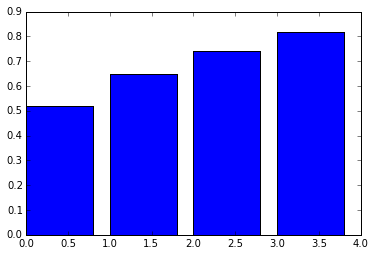

[(-1.0, 40.0, -0.66), (40.009999999999998, 60.0, -0.12), (60.009999999999998, 80.0, 0.32), (80.010000000000005, 100.0, 0.77)] 

IV: 0.295638450876


In [23]:
flag_rate, group_count, rank_group, information_value, groups, df_model['customer_value_woe'] = rude_group_rate(df_model, 'customer_value',rank_group=group)
print pd.DataFrame({'flag_rate':flag_rate, 'group_count': group_count}), '\n'
plt.figure()
plt.bar(flag_rate.index, flag_rate.values)
plt.show()
print groups, '\n'
print 'IV:', information_value

##### last_year_deal_orders

   flag_rate  group_count
0   0.515110       489078
1   0.590476       223833
2   0.678158       390524
3   0.766179       352377
4   0.854374       365841 



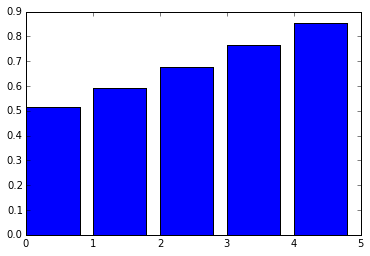

[(0, 0, -0.68), (1, 1, -0.37), (2, 4, 0.01), (5, 10, 0.45), (11, 286043, 1.03)] 

IV: 0.355926993281


In [24]:
flag_rate, group_count, rank_group, information_value, groups, df_model['last_year_deal_orders_woe'] = rude_group_rate(df_model, 'last_year_deal_orders', set=5)
print pd.DataFrame({'flag_rate':flag_rate, 'group_count': group_count}), '\n'
plt.figure()
plt.bar(flag_rate.index, flag_rate.values)
plt.show()
print groups, '\n'
print 'IV:', information_value

##### age
- 认为 age < 0 & age > 100 的数据不正常
- Hive 中已经做了处理

    flag_rate  group_count
2    0.452145       526543
5    0.690292        24465
6    0.683909       100003
7    0.726123        88368
8    0.747270       105116
9    0.758789        54699
10   0.769312       107513
11   0.779823        62922
12   0.783996       144789
13   0.785755        58167
14   0.791630       115549
15   0.792021        95351
16   0.788127        80317
17   0.785521        72520
18   0.776739       108223
19   0.750992        85941 



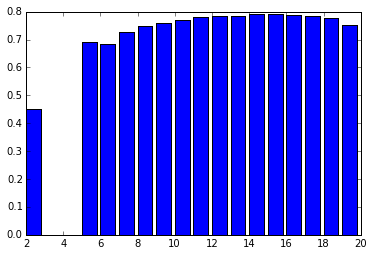

[(-1.0, -1.0, -0.92), (20.0, 24.0, 0.04), (0.0, 19.0, 0.07), (25.0, 26.0, 0.25), (27.0, 28.0, 0.36), (48.0, 100.0, 0.38), (29.0, 29.0, 0.42), (30.0, 31.0, 0.48), (44.0, 47.0, 0.52), (32.0, 32.0, 0.54), (33.0, 34.0, 0.56), (42.0, 43.0, 0.57), (35.0, 35.0, 0.57), (40.0, 41.0, 0.59), (36.0, 37.0, 0.61), (38.0, 39.0, 0.61)] 

IV: 0.417368768036


In [11]:
flag_rate, group_count, rank_group, information_value, groups, df_model['age_woe'] = rude_group_rate(df_model, 'age', set = 20)
print pd.DataFrame({'flag_rate':flag_rate, 'group_count': group_count}), '\n'
plt.figure()
plt.bar(flag_rate.index, flag_rate.values)
plt.show()
print groups, '\n'
print 'IV:', information_value

   flag_rate  group_count
0   0.452145       526543
1   0.685164       124468
2   0.742279       248183
3   0.779339       373391
4   0.789741       363737
5   0.765343       194164 



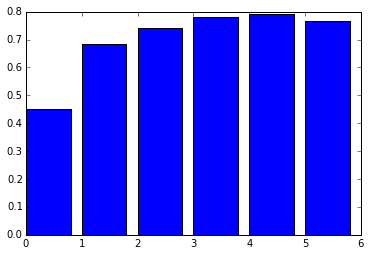

[(-1.0, -1.0, -0.92), (0.0, 24.0, 0.05), (25.0, 29.0, 0.33), (44.0, 100.0, 0.45), (30.0, 35.0, 0.53), (36.0, 43.0, 0.6)] 

IV: 0.415972932049


In [12]:
# 细分: [-1], [0,26] [27,33] [34]
group = rank_group.replace(2,0).replace([5,6],1).replace([7,8,9],2).replace([10,11,12,13],3).replace([14,15,16,17],4).replace([18,19],5)
flag_rate, group_count, rank_group, information_value, groups, df_model['age_woe'] = rude_group_rate(df_model, 'age', rank_group = group)
print pd.DataFrame({'flag_rate':flag_rate, 'group_count': group_count}), '\n'
plt.figure()
plt.bar(flag_rate.index, flag_rate.values)
plt.show()
print groups, '\n'
print 'IV:', information_value

##### city_num

   flag_rate  group_count
1   0.521298       499144
3   0.619072       368193
5   0.696909       247051
6   0.747262       178418
7   0.781183       133084
8   0.820177       226528
9   0.875049       169235 



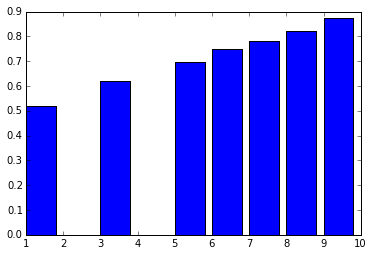

[(0, 0, -0.65), (1, 1, -0.25), (2, 2, 0.1), (3, 3, 0.35), (4, 4, 0.54), (5, 7, 0.78), (8, 1332, 1.21)] 

IV: 0.336438559747


In [29]:
flag_rate, group_count, rank_group, information_value, groups, df_model['city_num_woe'] = rude_group_rate(df_model, 'city_num', set=10)
print pd.DataFrame({'flag_rate':flag_rate, 'group_count': group_count}), '\n'
plt.figure()
plt.bar(flag_rate.index, flag_rate.values)
plt.show()
print groups, '\n'
print 'IV:', information_value

   flag_rate  group_count
0   0.521298       499144
1   0.619072       368193
2   0.696909       247051
3   0.761754       311502
4   0.843641       395763 



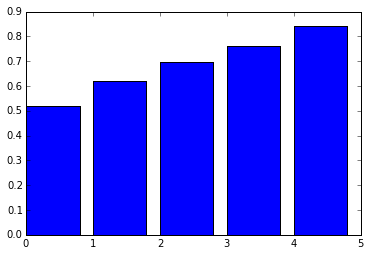

[(0, 0, -0.65), (1, 1, -0.25), (2, 2, 0.1), (3, 4, 0.43), (5, 1332, 0.95)] 

IV: 0.326800542094


In [30]:
#细分 [1] [3] [5] [6,7] [8,9]
group = rank_group.replace(1,0).replace(3,1).replace(5,2).replace([6,7],3).replace([8,9],4)
flag_rate, group_count, rank_group, information_value, groups, df_model['city_num_woe'] = rude_group_rate(df_model, 'city_num', rank_group=group)
print pd.DataFrame({'flag_rate':flag_rate, 'group_count': group_count}), '\n'
plt.figure()
plt.bar(flag_rate.index, flag_rate.values)
plt.show()
print groups, '\n'
print 'IV:', information_value

##### vip_grade

           flag_rate  group_count
vip_grade                        
0           0.581749      1090675
1           0.748726       300337
2           0.817851       174544
3           0.876888       264930 



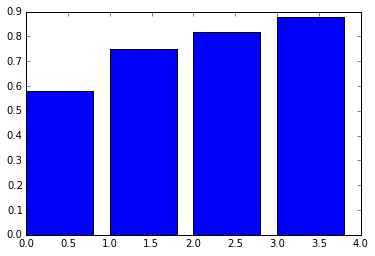

[(array([ 0, -1], dtype=int64), -0.4), (array([10], dtype=int64), 0.36), (array([20], dtype=int64), 0.77), (array([30], dtype=int64), 1.24)] 

IV: 0.333343491721


In [15]:
group = df_model.vip_grade.replace(-1,0).replace(10,1).replace(20,2).replace(30,3)
flag_rate, group_count, rank_group, information_value, groups, df_model['vip_grade_woe'] = rude_group_rate(df_model, 'vip_grade', rank_group=group)
print pd.DataFrame({'flag_rate':flag_rate, 'group_count': group_count}), '\n'
plt.figure()
plt.bar(flag_rate.index, flag_rate.values)
plt.show()
print groups, '\n'
print 'IV:', information_value

##### member_level

              flag_rate  group_count
member_level                        
0              0.574449      1050719
1              0.746982       322171
2              0.817489       186000
3              0.876817       271596 



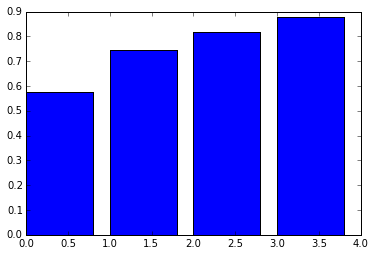

[(array([-1,  0], dtype=int64), -0.43), (array([10], dtype=int64), 0.35), (array([20], dtype=int64), 0.77), (array([30], dtype=int64), 1.23)] 

IV: 0.352386838608


In [16]:
group = df_model.member_level.replace(-1,0).replace(10,1).replace(20,2).replace(30,3)
flag_rate, group_count, rank_group, information_value, groups, df_model['member_level_woe'] = rude_group_rate(df_model, 'member_level', rank_group=group)
print pd.DataFrame({'flag_rate':flag_rate, 'group_count': group_count}), '\n'
plt.figure()
plt.bar(flag_rate.index, flag_rate.values)
plt.show()
print groups, '\n'
print 'IV:', information_value

##### avg_deal_price

   flag_rate  group_count
0   0.515110       489078
1   0.583999       239598
2   0.702591       364290
3   0.774121       364359
4   0.827891       364328 



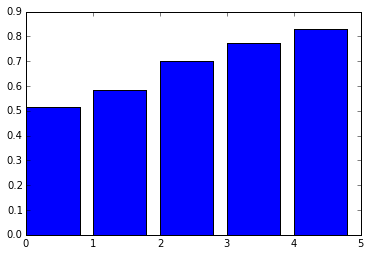

[(-1.0, -1.0, -0.68), (1.0, 275.25, -0.4), (275.26315789473682, 541.9677419354839, 0.12), (542.0, 990.25, 0.5), (990.26086956521749, 63200.0, 0.84)] 

IV: 0.318359045248


In [32]:
flag_rate, group_count, rank_group, information_value, groups, df_model['avg_deal_price_woe'] = rude_group_rate(df_model, 'avg_deal_price',set=5)
print pd.DataFrame({'flag_rate':flag_rate, 'group_count': group_count}), '\n'
plt.figure()
plt.bar(flag_rate.index, flag_rate.values)
plt.show()
print groups, '\n'
print 'IV:', information_value

##### real_name_certify

                   flag_rate  group_count
real_name_certify                        
0                   0.607878      1241206
1                   0.821748       580447 



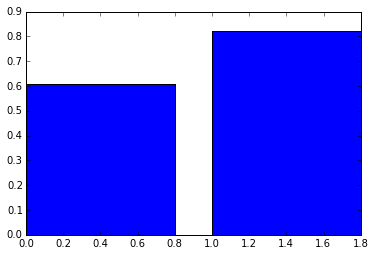

[(array([0], dtype=int64), -0.3), (array([1], dtype=int64), 0.79)] 

IV: 0.231051811529


In [33]:
group = df_model.real_name_certify.replace(-1,0)
flag_rate, group_count, rank_group, information_value, groups, df_model['real_name_certify_woe'] = rude_group_rate(df_model, 'real_name_certify',set=5)
print pd.DataFrame({'flag_rate':flag_rate, 'group_count': group_count}), '\n'
plt.figure()
plt.bar(flag_rate.index, flag_rate.values)
plt.show()
print groups, '\n'
print 'IV:', information_value

##### country_num


   flag_rate  group_count
0   0.515110       489078
3   0.724251      1244671
4   0.888469        87904 



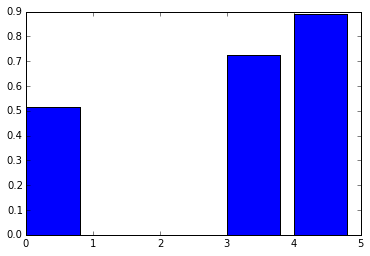

[(0, 0, -0.68), (1, 1, 0.23), (2, 45, 1.34)] 

IV: 0.230490679943


In [34]:
flag_rate, group_count, rank_group, information_value, groups, df_model['country_num_woe'] = rude_group_rate(df_model, 'country_num', set=5)
print pd.DataFrame({'flag_rate':flag_rate, 'group_count': group_count}), '\n'
plt.figure()
plt.bar(flag_rate.index, flag_rate.values)
plt.show()
print groups, '\n'
print 'IV:', information_value

##### bound_valid_email

                   flag_rate  group_count
bound_valid_email                        
0                   0.549796       742775
1                   0.762930      1078878 



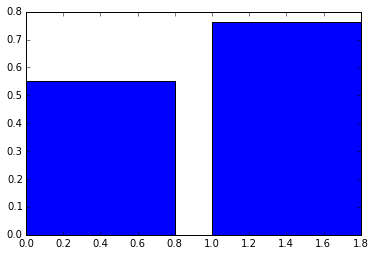

[(array([0], dtype=int64), -0.54), (array([1], dtype=int64), 0.43)] 

IV: 0.22770969511


In [35]:
group = df_model.bound_valid_email.replace(-1,0)
flag_rate, group_count, rank_group, information_value, groups, df_model['bound_valid_email_woe'] = rude_group_rate(df_model, 'bound_valid_email', rank_group=group)
print pd.DataFrame({'flag_rate':flag_rate, 'group_count': group_count}), '\n'
plt.figure()
plt.bar(flag_rate.index, flag_rate.values)
plt.show()
print groups, '\n'
print 'IV:', information_value

##### flt_generous_index

In [178]:
print df_model['flt_generous_index'].groupby(df_model['flt_generous_index']).count()
print 'nan: ', df_model['flt_generous_index'].isnull().sum()

flt_generous_index
-1    738318
 0    772678
 1     88245
 2     19849
 3    202335
Name: flt_generous_index, dtype: int64
nan:  0


                    flag_rate  group_count
flt_generous_index                        
-1                   0.565338       738419
 0                   0.741810       772761
 1                   0.775542       310473 



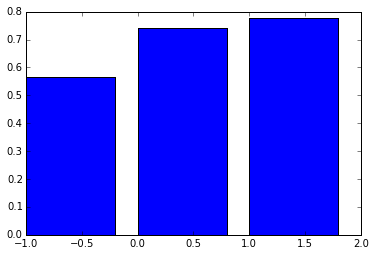

[(array([-1], dtype=int64), -0.47), (array([0], dtype=int64), 0.32), (array([3, 1, 2], dtype=int64), 0.5)] 

IV: 0.176648921724


In [39]:
# 细分: ['NaN'] [0], [1,2,3]
group = df_model['flt_generous_index'].replace([1,2,3],1)
flag_rate, group_count, rank_group, information_value, groups, df_model['flt_generous_index_woe'] = rude_group_rate(df_model, 'flt_generous_index',rank_group=group)
print pd.DataFrame({'flag_rate':flag_rate, 'group_count': group_count}), '\n'
plt.figure()
plt.bar(flag_rate.index, flag_rate.values)
plt.show()
print groups, '\n'
print 'IV:', information_value

##### base_active

             flag_rate  group_count
base_active                        
-1            0.581758       776374
 0            0.640288        39565
 1            0.665826       156990
 2            0.765808       848724 



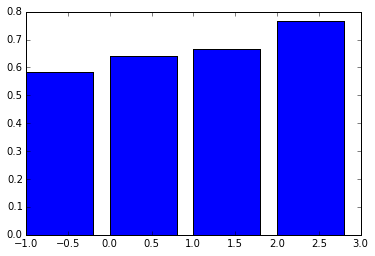

[(array([-1], dtype=int64), -0.41), (array([40], dtype=int64), -0.16), (array([60], dtype=int64), -0.05), (array([80], dtype=int64), 0.45)] 

IV: 0.160946005265


In [41]:
group = df_model.base_active.replace(40,0).replace(60,1).replace(80,2)
flag_rate, group_count, rank_group, information_value, groups, df_model['base_active_woe'] = rude_group_rate(df_model, 'base_active',rank_group=group)
print pd.DataFrame({'flag_rate':flag_rate, 'group_count': group_count}), '\n'
plt.figure()
plt.bar(flag_rate.index, flag_rate.values)
plt.show()
print groups, '\n'
print 'IV:', information_value

##### online_last_year_deal_orders

   flag_rate  group_count
3   0.628478      1317732
7   0.743310       166481
8   0.792604       148629
9   0.856767       188811 



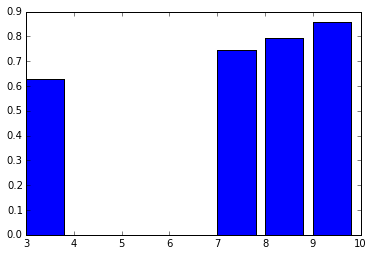

[(0, 0, -0.21), (1, 1, 0.33), (2, 3, 0.61), (4, 222335, 1.05)] 

IV: 0.158519239839


In [42]:
flag_rate, group_count, rank_group, information_value, groups, df_model['online_last_year_deal_orders_woe'] = rude_group_rate(df_model, 'online_last_year_deal_orders',set=10)
print pd.DataFrame({'flag_rate':flag_rate, 'group_count': group_count}), '\n'
plt.figure()
plt.bar(flag_rate.index, flag_rate.values)
plt.show()
print groups, '\n'
print 'IV:', information_value

##### phone_type

            flag_rate  group_count
phone_type                        
-1           0.561724       639536
 0           0.721791       715993
 1           0.762550       466124 



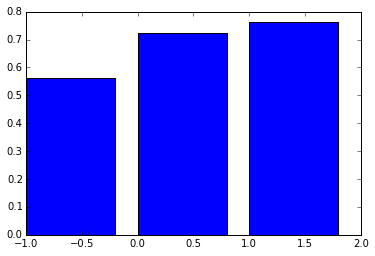

[(array([-1], dtype=int64), -0.49), (array([40], dtype=int64), 0.22), (array([90], dtype=int64), 0.43)] 

IV: 0.150774007622


In [43]:
group = df_model.phone_type.replace(40,0).replace(90,1)
flag_rate, group_count, rank_group, information_value, groups, df_model['phone_type_woe'] = rude_group_rate(df_model, 'phone_type',rank_group=group)
print pd.DataFrame({'flag_rate':flag_rate, 'group_count': group_count}), '\n'
plt.figure()
plt.bar(flag_rate.index, flag_rate.values)
plt.show()
print groups, '\n'
print 'IV:', information_value

##### flt_price_sitivity

                    flag_rate  group_count
flt_price_sitivity                        
-1                   0.594273       864276
 0                   0.728625       627427
 1                   0.789544       183544
 2                   0.790897       146406 



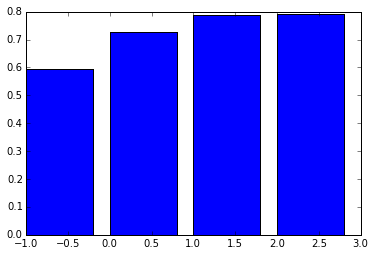

[(array([-1], dtype=int64), -0.35), (array([0], dtype=int64), 0.25), (array([1], dtype=int64), 0.59), (array([3, 2], dtype=int64), 0.59)] 

IV: 0.139235290575


In [45]:
group = rank_group.replace([2,3],2)
flag_rate, group_count, rank_group, information_value, groups, df_model['flt_price_sitivity_woe'] = rude_group_rate(df_model, 'flt_price_sitivity',rank_group=group)
print pd.DataFrame({'flag_rate':flag_rate, 'group_count': group_count}), '\n'
plt.figure()
plt.bar(flag_rate.index, flag_rate.values)
plt.show()
print groups, '\n'
print 'IV:', information_value

##### ratio_business_htl

     flag_rate  group_count
-10   0.390713        53794
 0    0.519864        82260
 1    0.737408        90711
 2    0.732053       174262
 3    0.715849       217627
 4    0.703605       336365
 5    0.697005       454569
 6    0.677302       302239
 7    0.582059        88979
 8    0.400647        17624
 9    0.283270         1052
 10   0.041916         2171 



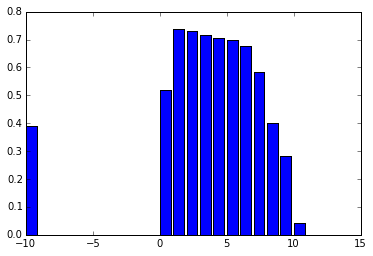

[(1.0, 1.0, -3.86), (0.90000000000000002, 0.98999999999999999, -1.66), (-1.0, -1.0, -1.18), (0.80000000000000004, 0.89686730024639216, -1.14), (0.0, 0.099974321328157922, -0.66), (0.70003946639847314, 0.7996594778660614, -0.4), (0.60000582452050155, 0.69999999999999996, 0.01), (0.5, 0.59999999999999998, 0.1), (0.40000000000000002, 0.49999976425630782, 0.13), (0.30000164772884697, 0.39999194880049571, 0.19), (0.20000000000000001, 0.29999999999999999, 0.27), (0.10000000000000001, 0.19992094861660081, 0.3)] 

IV: 0.124059843496


In [55]:
group = pd.Series(floor(i/0.1) for i in df_model.ratio_business_htl)
flag_rate, group_count, rank_group, information_value, groups, df_model['ratio_business_htl_woe']  = rude_group_rate(df_model, 'ratio_business_htl',rank_group=group)
print pd.DataFrame({'flag_rate':flag_rate, 'group_count': group_count}), '\n'
plt.figure()
plt.bar(flag_rate.index, flag_rate.values)
plt.show()
print groups, '\n'
print 'IV:', information_value

   flag_rate  group_count
0   0.576249       226765
1   0.714071       728254
2   0.697005       454569
3   0.677302       302239
4   0.539408       109826 



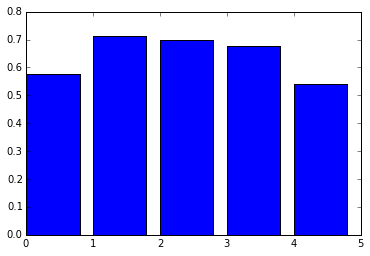

[(0.70003946639847314, 1.0, -0.58), (-1.0, 0.19992094861660081, -0.43), (0.60000582452050155, 0.69999999999999996, 0.01), (0.5, 0.59999999999999998, 0.1), (0.20000000000000001, 0.49999976425630782, 0.18)] 

IV: 0.0608183870285


In [56]:
group = rank_group.replace([-10,0,1],0).replace([2,3,4],1).replace(5,2).replace(6,3).replace([7,8,9,10],4)
flag_rate, group_count, rank_group, information_value, groups, df_model['ratio_business_htl_woe']  = rude_group_rate(df_model, 'ratio_business_htl',rank_group=group)
print pd.DataFrame({'flag_rate':flag_rate, 'group_count': group_count}), '\n'
plt.figure()
plt.bar(flag_rate.index, flag_rate.values)
plt.show()
print groups, '\n'
print 'IV:', information_value

##### bound_cell_phone

                  flag_rate  group_count
bound_cell_phone                        
0                  0.581664       251224
1                  0.691120      1570429 



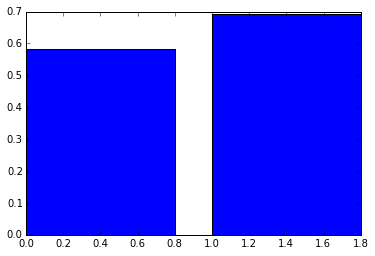

[(array([ 0, -1], dtype=int64), -0.41), (array([1], dtype=int64), 0.07)] 

IV: 0.0282679208064


In [57]:
group = df_model.bound_cell_phone.replace(-1,0)
flag_rate, group_count, rank_group, information_value, groups, df_model['bound_cell_phone_woe']  = rude_group_rate(df_model, 'bound_cell_phone',rank_group=group)
print pd.DataFrame({'flag_rate':flag_rate, 'group_count': group_count}), '\n'
plt.figure()
plt.bar(flag_rate.index, flag_rate.values)
plt.show()
print groups, '\n'
print 'IV:', information_value

##### fguarantee_last_year_noshow_orders

    flag_rate  group_count
7    0.690111      1415912
16   0.660204       249935
18   0.622429        85380
19   0.513958        70426 



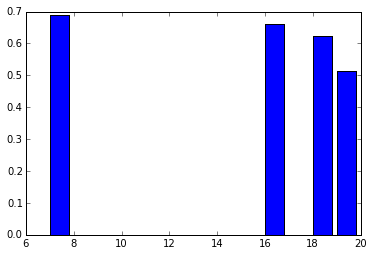

[(3, 103907, -0.68), (2, 2, -0.24), (1, 1, -0.07), (0, 0, 0.07)] 

IV: 0.0261088966068


In [58]:
flag_rate, group_count, rank_group, information_value, groups, df_model['fguarantee_last_year_noshow_orders_woe'] = rude_group_rate(df_model, 'fguarantee_last_year_noshow_orders',set=20)
print pd.DataFrame({'flag_rate':flag_rate, 'group_count': group_count}), '\n'
plt.figure()
plt.bar(flag_rate.index, flag_rate.values)
plt.show()
print groups, '\n'
print 'IV:', information_value

##### guarantee_last_year_deal_orders

   flag_rate  group_count
3   0.585564      1093115
6   0.754933       288211
8   0.819621       250262
9   0.887560       190065 



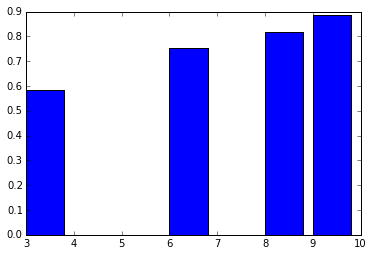

[(0, 0, -0.39), (1, 1, 0.39), (2, 3, 0.78), (4, 8763, 1.33)] 

IV: 0.323015893605


In [59]:
flag_rate, group_count, rank_group, information_value, groups, df_model['guarantee_last_year_deal_orders_woe'] = rude_group_rate(df_model, 'guarantee_last_year_deal_orders',set=10)
print pd.DataFrame({'flag_rate':flag_rate, 'group_count': group_count}), '\n'
plt.figure()
plt.bar(flag_rate.index, flag_rate.values)
plt.show()
print groups, '\n'
print 'IV:', information_value

##### fguarantee_last_year_deal_orders

   flag_rate  group_count
0   0.537180       551299
1   0.614314       243854
2   0.682099       302424
3   0.756271       357401
4   0.842594       366675 



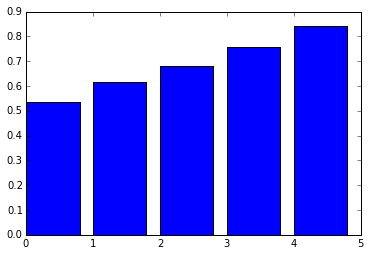

[(0, 0, -0.59), (1, 1, -0.27), (2, 3, 0.03), (4, 8, 0.4), (9, 286038, 0.94)] 

IV: 0.295594862927


In [60]:
flag_rate, group_count, rank_group, information_value, groups, df_model['fguarantee_last_year_deal_orders_woe'] = rude_group_rate(df_model, 'fguarantee_last_year_deal_orders',set=5)
print pd.DataFrame({'flag_rate':flag_rate, 'group_count': group_count}), '\n'
plt.figure()
plt.bar(flag_rate.index, flag_rate.values)
plt.show()
print groups, '\n'
print 'IV:', information_value

##### self_last_year_deal_orders 

   flag_rate  group_count
2   0.596233       995647
4   0.695610       169490
5   0.734527       205716
6   0.781958       232808
7   0.856894       217992 



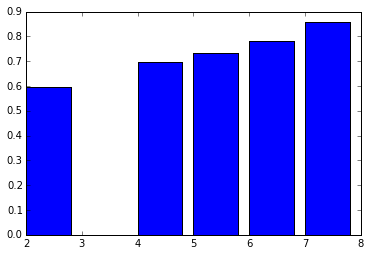

[(0, 0, -0.35), (1, 1, 0.09), (2, 3, 0.28), (4, 8, 0.54), (9, 305, 1.05)] 

IV: 0.215770563255


In [61]:
flag_rate, group_count, rank_group, information_value, groups, df_model['self_last_year_deal_orders_woe'] = rude_group_rate(df_model, 'self_last_year_deal_orders',set=8)
print pd.DataFrame({'flag_rate':flag_rate, 'group_count': group_count}), '\n'
plt.figure()
plt.bar(flag_rate.index, flag_rate.values)
plt.show()
print groups, '\n'
print 'IV:', information_value

##### last_year_noshow_orders

    flag_rate  group_count
7    0.689558      1410763
16   0.662483       252811
18   0.625437        86621
19   0.518081        71458 



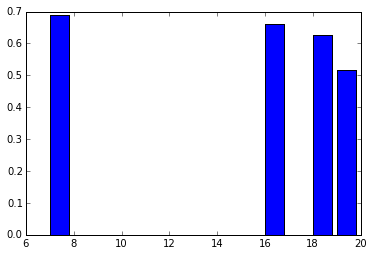

[(3, 103946, -0.66), (2, 2, -0.22), (1, 1, -0.06), (0, 0, 0.06)] 

IV: 0.0247246749732


In [62]:
flag_rate, group_count, rank_group, information_value, groups, df_model['last_year_noshow_orders_woe'] = rude_group_rate(df_model, 'last_year_noshow_orders',set=20)
print pd.DataFrame({'flag_rate':flag_rate, 'group_count': group_count}), '\n'
plt.figure()
plt.bar(flag_rate.index, flag_rate.values)
plt.show()
print groups, '\n'
print 'IV:', information_value

##### fguarantee_last_6m_deal_orders

   flag_rate  group_count
1   0.567083       734729
2   0.658114       275095
3   0.708543       184377
4   0.760696       301876
5   0.840086       325576 



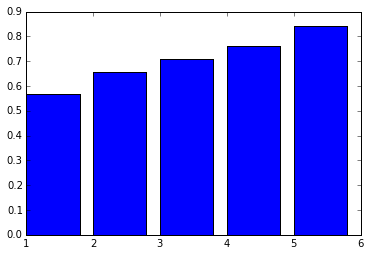

[(0, 0, -0.47), (1, 1, -0.08), (2, 2, 0.15), (3, 5, 0.42), (6, 68342, 0.92)] 

IV: 0.247284814406


In [65]:
flag_rate, group_count, rank_group, information_value, groups, df_model['fguarantee_last_6m_deal_orders_woe'] = rude_group_rate(df_model, 'fguarantee_last_6m_deal_orders',set=6)
print pd.DataFrame({'flag_rate':flag_rate, 'group_count': group_count}), '\n'
plt.figure()
plt.bar(flag_rate.index, flag_rate.values)
plt.show()
print groups, '\n'
print 'IV:', information_value

##### guarantee_last_6m_deal_orders

    flag_rate  group_count
7    0.615223      1286923
15   0.785053       267187
17   0.832005       123117
18   0.860972        60664
19   0.899191        83762 



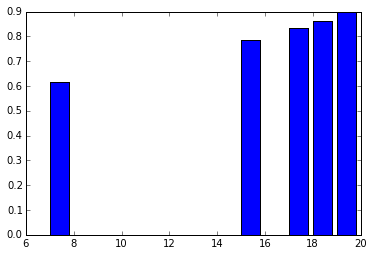

[(0, 0, -0.27), (1, 1, 0.56), (2, 2, 0.86), (3, 3, 1.09), (4, 6174, 1.45)] 

IV: 0.233347775826


In [66]:
flag_rate, group_count, rank_group, information_value, groups, df_model['guarantee_last_6m_deal_orders_woe'] = rude_group_rate(df_model, 'guarantee_last_6m_deal_orders',set=20)
print pd.DataFrame({'flag_rate':flag_rate, 'group_count': group_count}), '\n'
plt.figure()
plt.bar(flag_rate.index, flag_rate.values)
plt.show()
print groups, '\n'
print 'IV:', information_value

##### provice_num

   flag_rate  group_count
0   0.521298       499144
2   0.636614       455163
3   0.723226       295826
4   0.790151       332391
5   0.856981       239129 



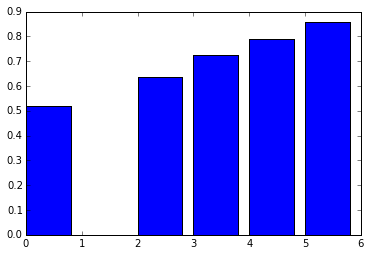

[(0, 0, -0.65), (1, 1, -0.17), (2, 2, 0.22), (3, 4, 0.59), (5, 34, 1.05)] 

IV: 0.312155202286


In [67]:
flag_rate, group_count, rank_group, information_value, groups, df_model['provice_num_woe'] = rude_group_rate(df_model, 'provice_num',set=6)
print pd.DataFrame({'flag_rate':flag_rate, 'group_count': group_count}), '\n'
plt.figure()
plt.bar(flag_rate.index, flag_rate.values)
plt.show()
print groups, '\n'
print 'IV:', information_value

##### offline_last_year_deal_orders 0值较多, 改为是否为 0¶

   flag_rate  group_count
1   0.660309      1353964
3   0.721524       467689 



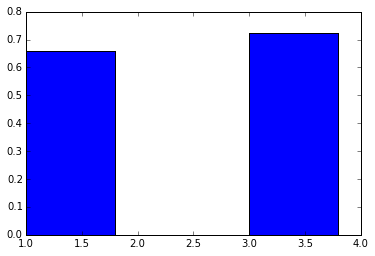

[(0, 0, -0.07), (1, 42528, 0.22)] 

IV: 0.0153270160863


In [74]:
flag_rate, group_count, rank_group, information_value, groups, df_model['offline_last_year_deal_orders_woe'] = rude_group_rate(df_model, 'offline_last_year_deal_orders',set=4)
print pd.DataFrame({'flag_rate':flag_rate, 'group_count': group_count}), '\n'
plt.figure()
plt.bar(flag_rate.index, flag_rate.values)
plt.show()
print groups, '\n'
print 'IV:', information_value

##### self_last_year_noshow_orders [0,1,null]

   flag_rate  group_count
0   0.677821      1607713
1   0.662527       213940 



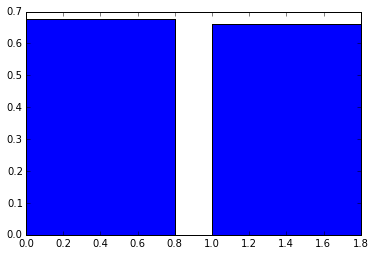

[(1, 50, -0.06), (0, 0, 0.01)] 

IV: 0.000500890789804


In [75]:
flag_rate, group_count, rank_group, information_value, groups, df_model['self_last_year_noshow_orders_woe'] = rude_group_rate(df_model, 'self_last_year_noshow_orders', set=2)
print pd.DataFrame({'flag_rate':flag_rate, 'group_count': group_count}), '\n'
plt.figure()
plt.bar(flag_rate.index, flag_rate.values)
plt.show()
print groups, '\n'
print 'IV:', information_value

##### online_last_6m_deal_orders

    flag_rate  group_count
5    0.645820      1476917
11   0.759914       138642
12   0.799903        70076
13   0.854666       136018 



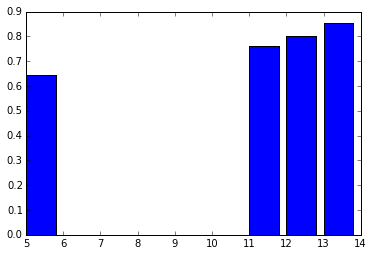

[(0, 0, -0.13), (1, 1, 0.42), (2, 2, 0.65), (3, 32012, 1.04)] 

IV: 0.104471350765


In [76]:
flag_rate, group_count, rank_group, information_value, groups, df_model['online_last_6m_deal_orders_woe'] = rude_group_rate(df_model, 'online_last_6m_deal_orders',set=14)
print pd.DataFrame({'flag_rate':flag_rate, 'group_count': group_count}), '\n'
plt.figure()
plt.bar(flag_rate.index, flag_rate.values)
plt.show()
print groups, '\n'
print 'IV:', information_value

##### last_6m_deal_orders 

   flag_rate  group_count
1   0.548767       665290
4   0.639409       258720
5   0.696404       179818
6   0.731615       133096
7   0.774675       247083
8   0.822161       160072
9   0.874852       177574 



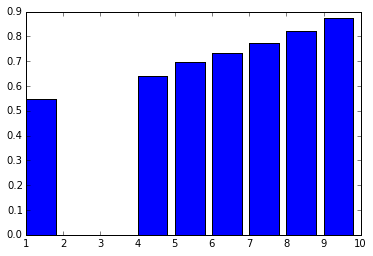

[(0, 0, -0.54), (1, 1, -0.16), (2, 2, 0.09), (3, 3, 0.27), (4, 6, 0.5), (7, 10, 0.8), (11, 74516, 1.21)] 

IV: 0.308392174433


In [77]:
flag_rate, group_count, rank_group, information_value, groups, df_model['last_6m_deal_orders_woe'] = rude_group_rate(df_model, 'last_6m_deal_orders',set=10)
print pd.DataFrame({'flag_rate':flag_rate, 'group_count': group_count}), '\n'
plt.figure()
plt.bar(flag_rate.index, flag_rate.values)
plt.show()
print groups, '\n'
print 'IV:', information_value

   flag_rate  group_count
0   0.548767       665290
1   0.639409       258720
2   0.711381       312914
3   0.793344       407155
4   0.874852       177574 



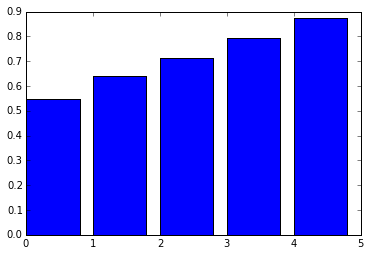

[(0, 0, -0.54), (1, 1, -0.16), (2, 3, 0.17), (4, 10, 0.61), (11, 74516, 1.21)] 

IV: 0.303025890543


In [78]:
group = rank_group.replace(1,0).replace(4,1).replace([5,6],2).replace([7,8],3).replace(9,4)
flag_rate, group_count, rank_group, information_value, groups, df_model['last_6m_deal_orders_woe'] = rude_group_rate(df_model, 'last_6m_deal_orders',rank_group=group)
print pd.DataFrame({'flag_rate':flag_rate, 'group_count': group_count}), '\n'
plt.figure()
plt.bar(flag_rate.index, flag_rate.values)
plt.show()
print groups, '\n'
print 'IV:', information_value

##### offline_last_year_noshow_orders

   flag_rate  group_count
0   0.684135      1710176
1   0.551612       111477 



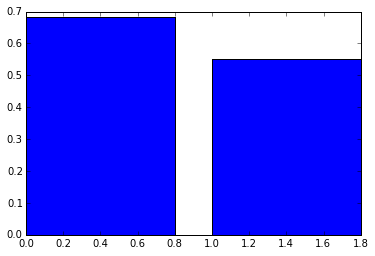

[(1, 8154, -0.53), (0, 0, 0.04)] 

IV: 0.0196636816516


In [79]:
flag_rate, group_count, rank_group, information_value, groups, df_model['offline_last_year_noshow_orders_woe'] = rude_group_rate(df_model, 'offline_last_year_noshow_orders',set=2)
print pd.DataFrame({'flag_rate':flag_rate, 'group_count': group_count}), '\n'
plt.figure()
plt.bar(flag_rate.index, flag_rate.values)
plt.show()
print groups, '\n'
print 'IV:', information_value

##### last_6m_noshow_orders

    flag_rate  group_count
8    0.688125      1559970
18   0.641351       180123
19   0.521162        81560 



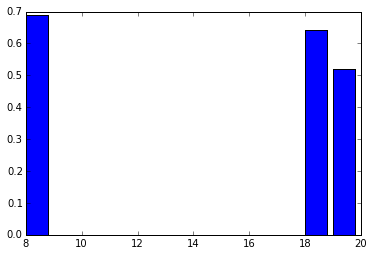

[(2, 78478, -0.65), (1, 1, -0.15), (0, 0, 0.06)] 

IV: 0.0256614017669


In [80]:
flag_rate, group_count, rank_group, information_value, groups, df_model['last_6m_noshow_orders_woe'] = rude_group_rate(df_model, 'last_6m_noshow_orders',set=20)
print pd.DataFrame({'flag_rate':flag_rate, 'group_count': group_count}), '\n'
plt.figure()
plt.bar(flag_rate.index, flag_rate.values)
plt.show()
print groups, '\n'
print 'IV:', information_value

##### recent5_noshow_rate

     flag_rate  group_count
-10   0.518352       355475
 0    0.761205      1099749
 2    0.684200       201241
 3    0.491940        19354
 4    0.564430        54625
 5    0.413254        43610
 6    0.323556         5523
 7    0.247603         1773
 8    0.289898         4712
 10   0.293108        35591 



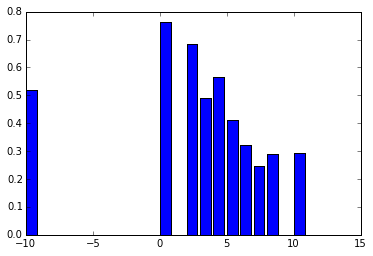

[(0.75, 0.75, -1.85), (0.80000000000000004, 0.80000000000000004, -1.63), (1.0, 1.0, -1.62), (0.66666666666666663, 0.66666666666666663, -1.47), (0.5, 0.59999999999999998, -1.09), (0.33333333333333331, 0.33333333333333331, -0.77), (-1.0, -1.0, -0.66), (0.40000000000000002, 0.40000000000000002, -0.48), (0.20000000000000001, 0.25, 0.04), (0.0, 0.0, 0.42)] 

IV: 0.311335431303


In [81]:
group = pd.Series([floor(i/0.1) for i in df_model.recent5_noshow_rate])
flag_rate, group_count, rank_group, information_value, groups, df_model['recent5_noshow_rate_woe'] = rude_group_rate(df_model, 'recent5_noshow_rate',rank_group=group)
print pd.DataFrame({'flag_rate':flag_rate, 'group_count': group_count}), '\n'
plt.figure()
plt.bar(flag_rate.index, flag_rate.values)
plt.show()
print groups, '\n'
print 'IV:', information_value

    flag_rate  group_count
-1   0.518352       355475
 0   0.761205      1099749
 1   0.684200       201241
 2   0.438282       165188 



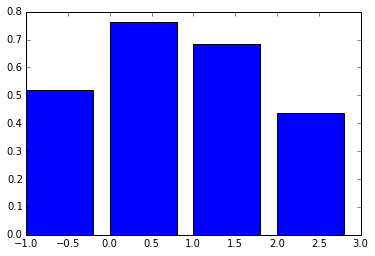

[(0.33333333333333331, 1.0, -0.98), (-1.0, -1.0, -0.66), (0.20000000000000001, 0.25, 0.04), (0.0, 0.0, 0.42)] 

IV: 0.289492726869


In [82]:
group = rank_group.replace(-10,-1).replace(2,1).replace(range(3,11),2)
flag_rate, group_count, rank_group, information_value, groups, df_model['recent5_noshow_rate_woe'] = rude_group_rate(df_model, 'recent5_noshow_rate',rank_group=group)
print pd.DataFrame({'flag_rate':flag_rate, 'group_count': group_count}), '\n'
plt.figure()
plt.bar(flag_rate.index, flag_rate.values)
plt.show()
print groups, '\n'
print 'IV:', information_value

##### recent10_noshow_rate

     flag_rate  group_count
-10   0.518352       355475
 0    0.764618       996352
 1    0.752976       202814
 2    0.619357       132686
 3    0.477564        28570
 4    0.437379        18668
 5    0.383312        40124
 6    0.286795         7800
 7    0.228151         2380
 8    0.158501         1735
 9    0.102041          245
 10   0.293932        34804 



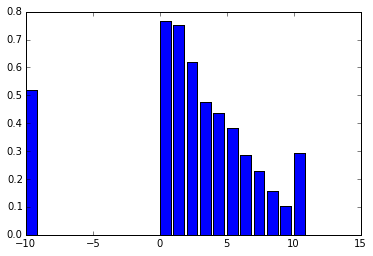

[(0.90000000000000002, 0.90000000000000002, -2.91), (0.80000000000000004, 0.88888888888888884, -2.4), (0.7142857142857143, 0.77777777777777779, -1.95), (0.625, 0.69999999999999996, -1.65), (1.0, 1.0, -1.61), (0.5, 0.59999999999999998, -1.21), (0.40000000000000002, 0.44444444444444442, -0.99), (0.33333333333333331, 0.375, -0.83), (-1.0, -1.0, -0.66), (0.20000000000000001, 0.29999999999999999, -0.25), (0.10000000000000001, 0.16666666666666666, 0.38), (0.0, 0.0, 0.44)] 

IV: 0.346779766181


In [84]:
group = pd.Series([floor(i/0.1) for i in df_model.recent10_noshow_rate])
flag_rate, group_count, rank_group, information_value, groups, df_model['recent10_noshow_rate_woe'] = rude_group_rate(df_model, 'recent10_noshow_rate',rank_group=group)
print pd.DataFrame({'flag_rate':flag_rate, 'group_count': group_count}), '\n'
plt.figure()
plt.bar(flag_rate.index, flag_rate.values)
plt.show()
print groups, '\n'
print 'IV:', information_value

    flag_rate  group_count
-1   0.518352       355475
 0   0.764618       996352
 1   0.752976       202814
 2   0.619357       132686
 3   0.375944       134326 



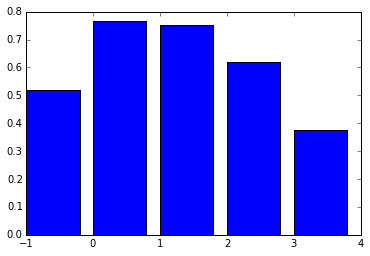

[(0.33333333333333331, 1.0, -1.24), (-1.0, -1.0, -0.66), (0.20000000000000001, 0.29999999999999999, -0.25), (0.10000000000000001, 0.16666666666666666, 0.38), (0.0, 0.0, 0.44)] 

IV: 0.335973750102


In [85]:
group = rank_group.replace(-10,-1).replace(range(3,11),3)
flag_rate, group_count, rank_group, information_value, groups, df_model['recent10_noshow_rate_woe'] = rude_group_rate(df_model, 'recent10_noshow_rate',rank_group=group)
print pd.DataFrame({'flag_rate':flag_rate, 'group_count': group_count}), '\n'
plt.figure()
plt.bar(flag_rate.index, flag_rate.values)
plt.show()
print groups, '\n'
print 'IV:', information_value

##### recent15_noshow_rate

     flag_rate  group_count
-10   0.518352       355475
 0    0.769997      1100482
 1    0.702949       129823
 2    0.583646        98714
 3    0.471347        38076
 4    0.382353        15436
 5    0.378090        36769
 6    0.284222         7656
 7    0.215788         2711
 8    0.145272         1597
 9    0.061350          163
 10   0.294294        34751 



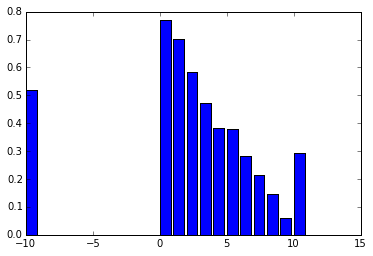

[(0.90000000000000002, 0.93333333333333324, -3.46), (0.80000000000000004, 0.88888888888888884, -2.51), (0.7142857142857143, 0.7857142857142857, -2.03), (0.61538461538461542, 0.69999999999999996, -1.66), (1.0, 1.0, -1.61), (0.5, 0.59999999999999998, -1.23), (0.40000000000000002, 0.46666666666666667, -1.22), (0.30769230769230771, 0.38461538461538464, -0.85), (-1.0, -1.0, -0.66), (0.20000000000000001, 0.29999999999999999, -0.4), (0.10000000000000001, 0.18181818181818185, 0.13), (0.0, 0.090909090909090925, 0.47)] 

IV: 0.36857001624


In [86]:
group = pd.Series([floor(i/0.1) for i in df_model.recent15_noshow_rate])
flag_rate, group_count, rank_group, information_value, groups, df_model['recent15_noshow_rate_woe'] = rude_group_rate(df_model, 'recent15_noshow_rate',rank_group=group)
print pd.DataFrame({'flag_rate':flag_rate, 'group_count': group_count}), '\n'
plt.figure()
plt.bar(flag_rate.index, flag_rate.values)
plt.show()
print groups, '\n'
print 'IV:', information_value

    flag_rate  group_count
-1   0.518352       355475
 0   0.769997      1100482
 1   0.702949       129823
 2   0.583646        98714
 3   0.371693       137159 



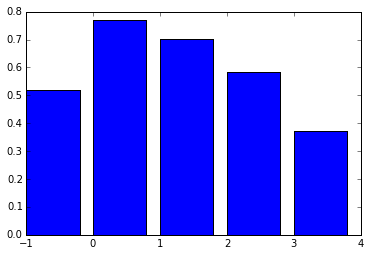

[(0.30769230769230771, 1.0, -1.26), (-1.0, -1.0, -0.66), (0.20000000000000001, 0.29999999999999999, -0.4), (0.10000000000000001, 0.18181818181818185, 0.13), (0.0, 0.090909090909090925, 0.47)] 

IV: 0.357628569167


In [87]:
group = rank_group.replace(-10,-1).replace(range(3,11),3)
flag_rate, group_count, rank_group, information_value, groups, df_model['recent15_noshow_rate_woe'] = rude_group_rate(df_model, 'recent15_noshow_rate',rank_group=group)
print pd.DataFrame({'flag_rate':flag_rate, 'group_count': group_count}), '\n'
plt.figure()
plt.bar(flag_rate.index, flag_rate.values)
plt.show()
print groups, '\n'
print 'IV:', information_value

##### recent20_noshow_rate

     flag_rate  group_count
-10   0.518352       355475
 0    0.770296      1076087
 1    0.715278       166099
 2    0.560306        90281
 3    0.461657        36395
 4    0.367626        13696
 5    0.377393        36768
 6    0.282194         7711
 7    0.213592         2678
 8    0.146169         1553
 9    0.063218          174
 10   0.294392        34736 



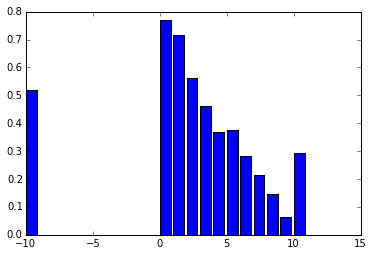

[(0.90000000000000002, 0.94999999999999996, -3.43), (0.80000000000000004, 0.89473684210526316, -2.5), (0.70588235294117652, 0.78947368421052633, -2.04), (0.61111111111111116, 0.69999999999999996, -1.67), (1.0, 1.0, -1.61), (0.40000000000000002, 0.47368421052631582, -1.28), (0.5, 0.59999999999999998, -1.24), (0.30769230769230771, 0.3888888888888889, -0.89), (-1.0, -1.0, -0.66), (0.20000000000000001, 0.29999999999999999, -0.49), (0.10000000000000001, 0.1875, 0.19), (0.0, 0.090909090909090925, 0.47)] 

IV: 0.373125535381


In [93]:
group = pd.Series([floor(i/0.1) for i in df_model.recent20_noshow_rate])
flag_rate, group_count, rank_group, information_value, groups, df_model['recent20_noshow_rate_woe'] = rude_group_rate(df_model, 'recent20_noshow_rate',rank_group=group)
print pd.DataFrame({'flag_rate':flag_rate, 'group_count': group_count}), '\n'
plt.figure()
plt.bar(flag_rate.index, flag_rate.values)
plt.show()
print groups, '\n'
print 'IV:', information_value

    flag_rate  group_count
-1   0.518352       355475
 0   0.770296      1076087
 1   0.715278       166099
 2   0.560306        90281
 3   0.365901       133711 



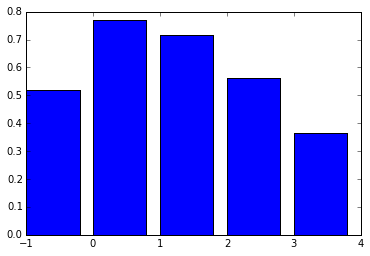

[(0.30769230769230771, 1.0, -1.29), (-1.0, -1.0, -0.66), (0.20000000000000001, 0.29999999999999999, -0.49), (0.10000000000000001, 0.1875, 0.19), (0.0, 0.090909090909090925, 0.47)] 

IV: 0.363190313471


In [94]:
group = rank_group.replace(-10,-1).replace(range(3,11),3)
flag_rate, group_count, rank_group, information_value, groups, df_model['recent20_noshow_rate_woe'] = rude_group_rate(df_model, 'recent20_noshow_rate',rank_group=group)
print pd.DataFrame({'flag_rate':flag_rate, 'group_count': group_count}), '\n'
plt.figure()
plt.bar(flag_rate.index, flag_rate.values)
plt.show()
print groups, '\n'
print 'IV:', information_value

##### last_6m_deal_amount

   flag_rate  group_count
1   0.548767       665290
2   0.588578       245728
3   0.706969       303449
4   0.792988       303591
5   0.877785       303595 



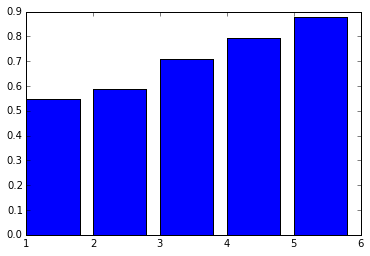

[(0.0, 0.0, -0.54), (1.0, 658.0, -0.38), (659.0, 1983.0, 0.15), (1984.0, 5399.0, 0.61), (5400.0, 56569961.0, 1.24)] 

IV: 0.382145766364


In [95]:
flag_rate, group_count, rank_group, information_value, groups, df_model['last_6m_deal_amount_woe'] = rude_group_rate(df_model, 'last_6m_deal_amount', set = 6)
print pd.DataFrame({'flag_rate':flag_rate, 'group_count': group_count}), '\n'
plt.figure()
plt.bar(flag_rate.index, flag_rate.values)
plt.show()
print groups, '\n'
print 'IV:', information_value

##### self_last_6m_deal_orders

   flag_rate  group_count
3   0.610588      1136995
6   0.725225       185799
7   0.756017       118832
8   0.788485       188838
9   0.856566       191189 



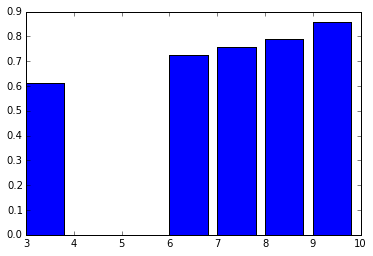

[(0, 0, -0.29), (1, 1, 0.23), (2, 2, 0.4), (3, 5, 0.58), (6, 146, 1.05)] 

IV: 0.189954639049


In [96]:
flag_rate, group_count, rank_group, information_value, groups, df_model['self_last_6m_deal_orders_woe'] = rude_group_rate(df_model, 'self_last_6m_deal_orders', set = 10)
print pd.DataFrame({'flag_rate':flag_rate, 'group_count': group_count}), '\n'
plt.figure()
plt.bar(flag_rate.index, flag_rate.values)
plt.show()
print groups, '\n'
print 'IV:', information_value

##### oversea_flag

              flag_rate  group_count
oversea_flag                        
0              0.664477      1724814
1              0.881701        96839 



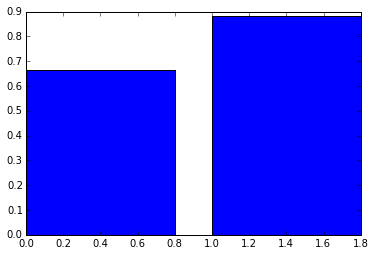

[(array([0], dtype=int64), -0.05), (array([1], dtype=int64), 1.27)] 

IV: 0.0661628698085


In [97]:
flag_rate, group_count, rank_group, information_value, groups, df_model['oversea_flag_woe'] = rude_group_rate(df_model, 'oversea_flag')
print pd.DataFrame({'flag_rate':flag_rate, 'group_count': group_count}), '\n'
plt.figure()
plt.bar(flag_rate.index, flag_rate.values)
plt.show()
print groups, '\n'
print 'IV:', information_value

##### fguarantee_last_6m_noshow_orders

    flag_rate  group_count
4    0.688443      1563637
9    0.638642       177569
10   0.517173        80447 



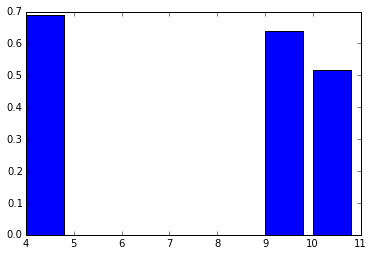

[(2, 78445, -0.67), (1, 1, -0.17), (0, 0, 0.06)] 

IV: 0.0269108358398


In [98]:
flag_rate, group_count, rank_group, information_value, groups, df_model['fguarantee_last_6m_noshow_orders_woe'] = rude_group_rate(df_model, 'fguarantee_last_6m_noshow_orders',set=11)
print pd.DataFrame({'flag_rate':flag_rate, 'group_count': group_count}), '\n'
plt.figure()
plt.bar(flag_rate.index, flag_rate.values)
plt.show()
print groups, '\n'
print 'IV:', information_value

##### offline_last_6m_noshow_orders

   flag_rate  group_count
0   0.681223      1762683
1   0.520638        58970 



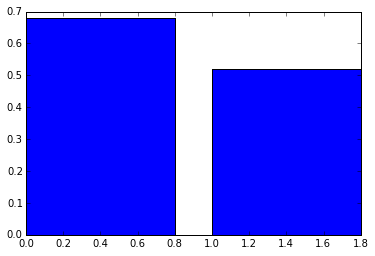

[(1, 7666, -0.65), (0, 0, 0.02)] 

IV: 0.0155442251077


In [99]:
flag_rate, group_count, rank_group, information_value, groups, df_model['offline_last_6m_noshow_orders_woe'] = rude_group_rate(df_model, 'offline_last_6m_noshow_orders',set=2)
print pd.DataFrame({'flag_rate':flag_rate, 'group_count': group_count}), '\n'
plt.figure()
plt.bar(flag_rate.index, flag_rate.values)
plt.show()
print groups, '\n'
print 'IV:', information_value

##### min_deal_price

    flag_rate  group_count
8    0.668163      1522004
16   0.624390        26232
17   0.674771        91228
18   0.732006        91144
19   0.767555        91045 



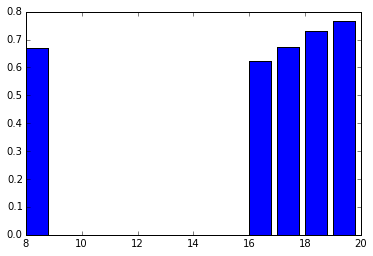

[(1.0, 136.0, -0.23), (0.0, 0.0, -0.04), (137.0, 288.0, -0.01), (289.0, 567.0, 0.27), (568.0, 63200.0, 0.46)] 

IV: 0.0148740967725


In [100]:
flag_rate, group_count, rank_group, information_value, groups, df_model['min_deal_price_woe'] = rude_group_rate(df_model, 'min_deal_price',set=20)
print pd.DataFrame({'flag_rate':flag_rate, 'group_count': group_count}), '\n'
plt.figure()
plt.bar(flag_rate.index, flag_rate.values)
plt.show()
print groups, '\n'
print 'IV:', information_value

   flag_rate  group_count
0   0.667421      1548236
1   0.674771        91228
2   0.732006        91144
3   0.767555        91045 



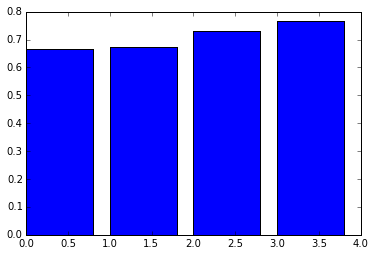

[(0.0, 136.0, -0.04), (137.0, 288.0, -0.01), (289.0, 567.0, 0.27), (568.0, 63200.0, 0.46)] 

IV: 0.0143350328964


In [101]:
group = rank_group.replace([8,16],0).replace(17,1).replace(18,2).replace(19,3)
flag_rate, group_count, rank_group, information_value, groups, df_model['min_deal_price_woe'] = rude_group_rate(df_model, 'min_deal_price',rank_group=group)
print pd.DataFrame({'flag_rate':flag_rate, 'group_count': group_count}), '\n'
plt.figure()
plt.bar(flag_rate.index, flag_rate.values)
plt.show()
print groups, '\n'
print 'IV:', information_value

##### offline_last_6m_deal_orders

   flag_rate  group_count
0   0.668071      1511976
1   0.714861       309677 



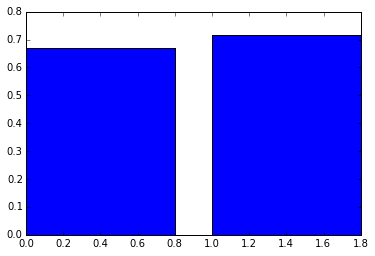

[(0, 0, -0.04), (1, 11705, 0.18)] 

IV: 0.00662082325905


In [102]:
flag_rate, group_count, rank_group, information_value, groups, df_model['offline_last_6m_deal_orders_woe'] = rude_group_rate(df_model, 'offline_last_6m_deal_orders',set=2)
print pd.DataFrame({'flag_rate':flag_rate, 'group_count': group_count}), '\n'
plt.figure()
plt.bar(flag_rate.index, flag_rate.values)
plt.show()
print groups, '\n'
print 'IV:', information_value

##### self_last_6m_noshow_orders

   flag_rate  group_count
0   0.678484      1691618
1   0.644042       130035 



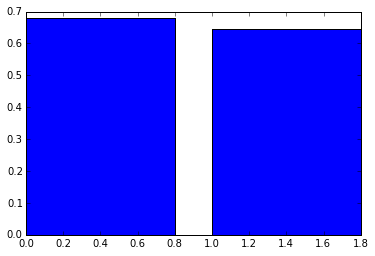

[(1, 41, -0.14), (0, 0, 0.01)] 

IV: 0.00160386146708


In [103]:
flag_rate, group_count, rank_group, information_value, groups, df_model['self_last_6m_noshow_orders_woe'] = rude_group_rate(df_model, 'self_last_6m_noshow_orders',set=2)
print pd.DataFrame({'flag_rate':flag_rate, 'group_count': group_count}), '\n'
plt.figure()
plt.bar(flag_rate.index, flag_rate.values)
plt.show()
print groups, '\n'
print 'IV:', information_value

##### online_last_6m_noshow_orders

   flag_rate  group_count
0   0.677163      1780759
1   0.626473        40894 



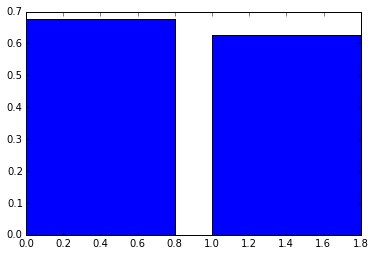

[(1, 1223, -0.22), (0, 0, 0.01)] 

IV: 0.0011359052907


In [104]:
flag_rate, group_count, rank_group, information_value, groups, df_model['online_last_6m_noshow_orders_woe'] = rude_group_rate(df_model, 'online_last_6m_noshow_orders',set=2)
print pd.DataFrame({'flag_rate':flag_rate, 'group_count': group_count}), '\n'
plt.figure()
plt.bar(flag_rate.index, flag_rate.values)
plt.show()
print groups, '\n'
print 'IV:', information_value